# FMA Genre Classification


In [ ]:
PREPROCESSING = False

In [ ]:
NORMALIZE_DATA = False

# Libraries & utils

In [ ]:
!pip install librosa > /dev/null
!pip install pyts sktime==0.30.0 > /dev/null
!pip install git+https://github.com/gon-uri/detach_rocket > /dev/null
!pip install aeon > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/gon-uri/detach_rocket /tmp/pip-req-build-xung5qw4


In [ ]:
# from google.colab import drive
from datetime import datetime
import os
import logging

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from IPython.display import Audio, display
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from detach_rocket.detach_classes import DetachEnsemble
from sklearn.metrics import accuracy_score

from aeon.classification.deep_learning import InceptionTimeClassifier

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# drive.mount('/content/drive')

In [ ]:
# change to False if you dont want to persist the experiments output on drive
LOG_EXPERIMENTS = True

In [ ]:
if LOG_EXPERIMENTS:
  now = datetime.now()
  formatted_time = now.strftime('%Y-%m-%d%H:%M:%S')

  folder_path = './' # folder location
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  log_file_path = f'{folder_path}/log_{formatted_time}.txt'

  logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s %(message)s', force=True)

In [ ]:
def log(to_log):
  """Save it to google drive and display it on the console

  Args:
    value: The value to log.
  """
  out = to_log
  if not isinstance(out, str):
    try:
      out = str(to_log)
    except Exception as e:
      try:
        out = to_log.to_string()
      except Exception as e:
        print(f"Error in log: {e}")

  if LOG_EXPERIMENTS:
    logging.info(out)
  print(out)

# Load dataset

In [ ]:
log("Loading dataset")

Loading dataset


In [ ]:
# copy dataset
# !cp -r /content/drive/MyDrive/fma_small .

In [ ]:
# copy metadata
# !cp -r /content/drive/MyDrive/fma_metadata .

# Analysis

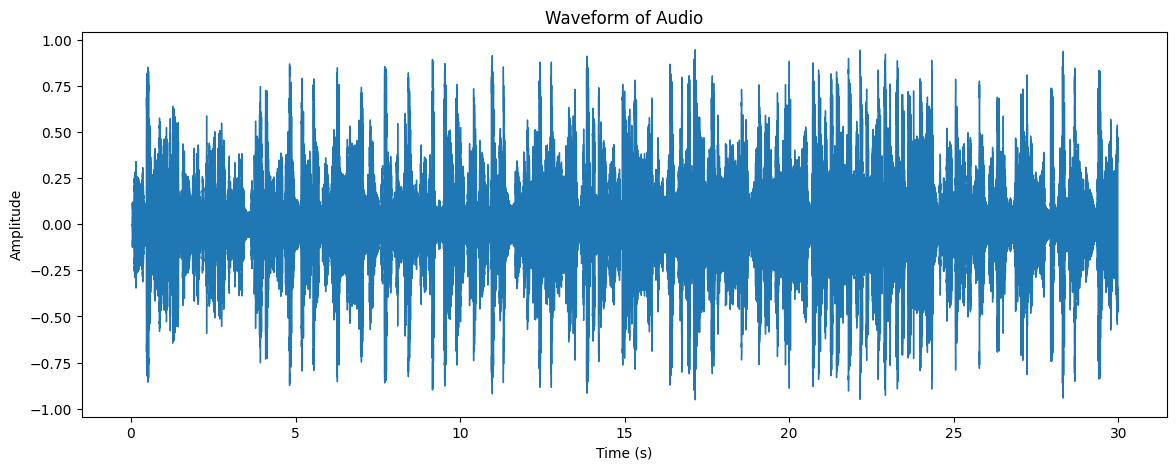

In [ ]:
# prompt: load FMA dataset and show an audio sample

# Path to the audio file (replace with an actual path from the dataset)
audio_file = 'fma_small/000/000002.mp3'

# Load the audio file
try:
    y, sr = librosa.load(audio_file)
    # Display the waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform of Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
except FileNotFoundError:
    print(f"Error: Audio file not found at {audio_file}. Please check the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
try:
    # Load the audio file using librosa
    y, sr = librosa.load(audio_file)

    # Play the audio clip
    display(ipd.Audio(audio_file))

except FileNotFoundError:
    print(f"Error: Audio file not found at {audio_file}. Please check the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# Load the tracks metadata
tracks_df = pd.read_csv('fma_metadata/tracks.csv', index_col=0, header=[0, 1])
tracks_df.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                                                            \
         producer tags                 title tracks   type   
track_id                                                     
2             NaN   []  AWOL - A Way Of Life      7  Album   
3             NaN   []  AWOL - A Way Of Life      7  Album   
5             NaN   []  AWOL - A Way Of Life      7  Album   
10            NaN   []     Constant Hitmaker      2  Album   
20            NaN   []                 Niris     13  Album   

                       artist                       \
            active_year_begin      active_year_end   
track_id                                             
2         2006-01-01 00:00:00                  NaN   
3         2006-01-01 00:00:00                  NaN   
5         2006-01-01 00:00:00                  NaN   
10                        NaN                  NaN   
20        1990-01-01 00:00:00  2011-01-01 00:00:00   

                                                             \
                                          associated_labels   
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                                      \
                                                        bio comments   
track_id                                                               
2         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
10        <p><span style="font-family:Verdana, Geneva, A...        3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...        2   

                                                                           \
                 date_created favorites id   latitude            location   
track_id                                                                    
2         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
3         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
5         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
10        2008-11-26 01:42:55        74  6        NaN                 NaN   
20        2008-11-26 01:42:52        10  4  51.895927  Colchester England   

                                                                        \
          longitude                                            members   
track_id                                         

In [ ]:
def get_genre_from_metadata(audio_file):
  try:
      # Extract track ID from the file path
      track_id = int(audio_file.split('/')[-1].split('.')[0])

      # Get the genre from the tracks dataframe
      genre = tracks_df.loc[track_id, ('track', 'genre_top')]

      return genre

  except FileNotFoundError:
      print(f"Error: Audio file not found at {audio_file}. Please check the file path.")
      return None
  except KeyError:
      print(f"Error: Track ID {track_id} not found in the metadata.")
      return None
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      return None

# Path to the audio file
audio_file = 'fma_small/000/000002.mp3'
print(f"The genre of the audio file is: {get_genre_from_metadata(audio_file)}")

The genre of the audio file is: Hip-Hop


# Preprocessing

In [ ]:
mp3_files = []
for r, d, f in os.walk('fma_small'):
    for file in f:
        if '.mp3' in file:
            mp3_files.append(os.path.join(r, file))
mp3_files[:5]

['fma_small/085/085307.mp3',
 'fma_small/085/085693.mp3',
 'fma_small/085/085955.mp3',
 'fma_small/085/085309.mp3',
 'fma_small/085/085952.mp3']

In [ ]:
files, genres = [], []
for file in mp3_files:
  genre = get_genre_from_metadata(file)
  if genre is not None:
    files.append(file)
    genres.append(genre)

df = pd.DataFrame({'file': files, 'genre': genres})
df.head()

file genre
0  fma_small/085/085307.mp3   Pop
1  fma_small/085/085693.mp3  Folk
2  fma_small/085/085955.mp3   Pop
3  fma_small/085/085309.mp3   Pop
4  fma_small/085/085952.mp3   Pop

In [ ]:
class_weights = df['genre'].value_counts(normalize=True)
class_weights

genre
Pop              0.125
Folk             0.125
Electronic       0.125
Experimental     0.125
Rock             0.125
Instrumental     0.125
Hip-Hop          0.125
International    0.125
Name: proportion, dtype: float64

### Extract features

In [ ]:
def get_mfcc_from_audio(y, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def get_chromas_from_audio(y, sr, n_chroma=12, n_fft=2048, hop_length=512):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma, n_fft=n_fft, hop_length=hop_length)
    return chroma

def get_spectral_from_audio(y, sr, n_fft=2048, hop_length=512):
    spectral = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return spectral

def extract_audio_features(file_path, n_mfcc=13, n_chroma=12, n_fft=2048, hop_length=512):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            y, sr = librosa.load(file_path)
    except Exception as e:
        return None

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma, n_fft=n_fft, hop_length=hop_length)
    spectral = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    return {
        'mfcc': mfcc,
        'chroma': chroma,
        'spectral': spectral,
        # 'raw': y,
        # 'sr': sr,
    }


### Execute and save or load preprocessing features

---



In [ ]:
if PREPROCESSING:
  # filter out files that could not be read
  features = df['file'].apply(extract_audio_features)
  df = df[features.notnull()]
  df = pd.concat([df, features.apply(pd.Series)], axis=1)
  df = df.dropna()
  display(df.head())

  df.to_pickle('features.pkl')
else:
  df = pd.read_pickle('features_all.pkl')

log(f"Number of files: {len(df)}")

Number of files: 7994


In [ ]:
name_of_features = df.columns[df.columns.get_loc('genre') + 1:].tolist()
name_of_features.remove('tempo')
name_of_features.remove('sr')
# name_of_features.remove('label')
log(f'Features that we have: {name_of_features}')

Features that we have: ['raw', 'mfcc', 'chroma', 'spectral']


Check MFCC plot

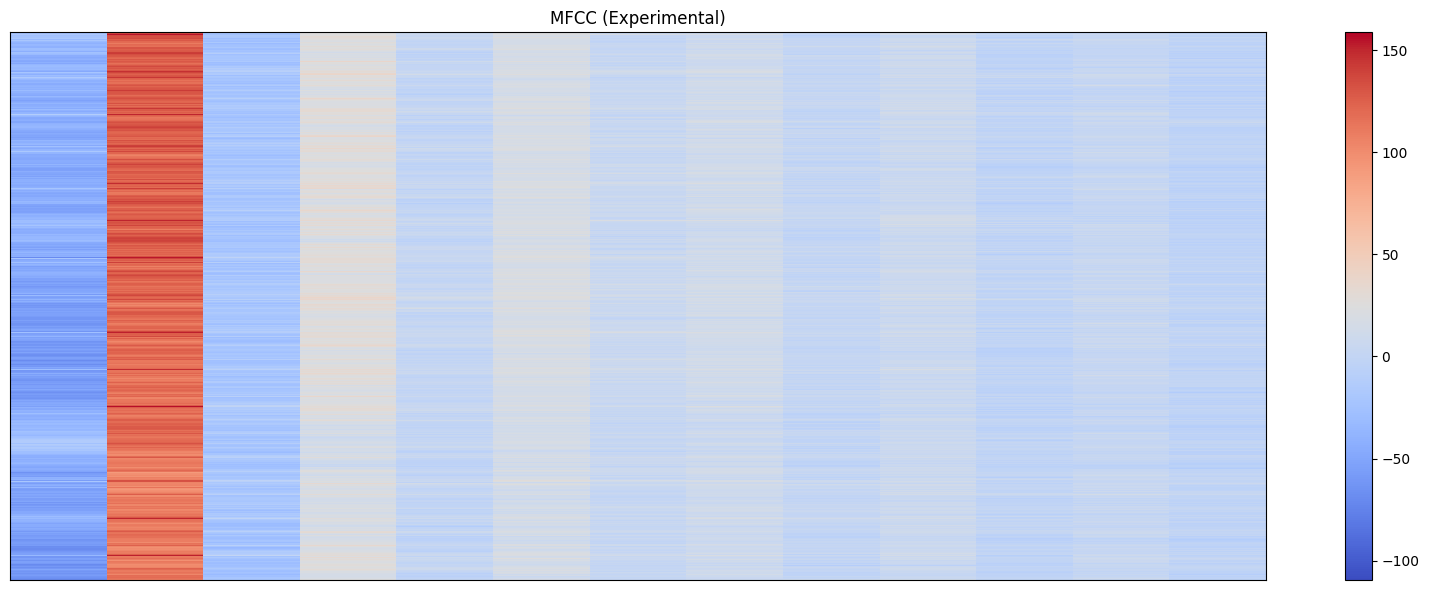

In [ ]:
def plot(x, y, title='MFCC'):
    plt.figure(figsize=(16, 6))
    librosa.display.specshow(np.transpose(x))
    plt.colorbar()
    plt.title(f'{title} ({y})')
    plt.tight_layout()
    plt.show()

plot(df.loc[0, 'mfcc'], df.loc[0, 'genre'])

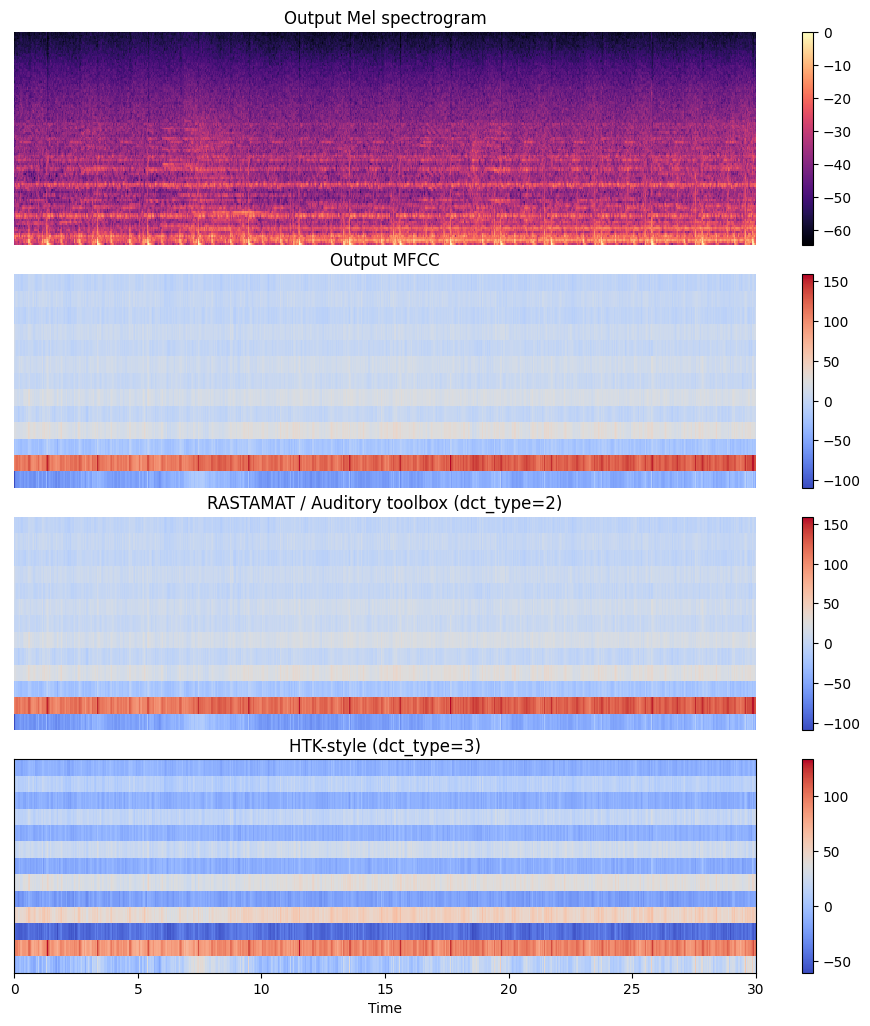

In [ ]:
# plotting Mel spectrogram, MFCC, and MFCC with different DCT types
y, sr = librosa.load(df.loc[0, 'file'])
mfcc_data_output = df.loc[0, 'mfcc']
mfcc_data_2 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, dct_type=2)
mfcc_data_3 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, dct_type=3)

fig, ax = plt.subplots(nrows=4, sharex=True, sharey=False, figsize=(10,10))
fig.tight_layout()

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
img0 = librosa.display.specshow(
    librosa.power_to_db(S, ref=np.max),
    x_axis='time', y_axis='mel',
    fmax=8000, ax=ax[0])
ax[0].set(title='Output Mel spectrogram')
ax[0].axis('off')
fig.colorbar(img0, ax=[ax[0]])

img1 = librosa.display.specshow(mfcc_data_output, x_axis='time', ax=ax[1])
ax[1].set(title='Output MFCC')
ax[1].axis('off')
fig.colorbar(img1, ax=[ax[1]])

img2 = librosa.display.specshow(mfcc_data_2, x_axis='time', ax=ax[2])
ax[2].set(title='RASTAMAT / Auditory toolbox (dct_type=2)')
ax[2].axis('off')
fig.colorbar(img2, ax=[ax[2]])

img3 = librosa.display.specshow(mfcc_data_3, x_axis='time', ax=ax[3])
ax[3].set(title='HTK-style (dct_type=3)')
fig.colorbar(img3, ax=[ax[3]])




### Normalize Data

In [ ]:
# get the minimum, mean, and maximum number of frames for the raw data
# print('min: {}, mean: {}, max: {}'.format(
#     np.min([row[1]['raw'].shape[0] for row in df.iterrows()], axis=0),
#     np.mean([row[1]['raw'].shape[0] for row in df.iterrows()], axis=0),
#     np.max([row[1]['raw'].shape[0] for row in df.iterrows()], axis=0))
# )

In [ ]:
def pad_to_length(array, target_length):
    if array.shape[1] < target_length:
        padding = np.zeros((array.shape[0], target_length - array.shape[1]))
        return np.hstack((array, padding))
    elif array.shape[1] > target_length:
        return array[:, :target_length]
    return array


# Uniformizar os tamanhos
target_length = 1291
df.loc[:, 'mfcc'] = df.loc[:, 'mfcc'].apply(lambda x: pad_to_length(x, target_length))
df.loc[:, 'chroma'] = df.loc[:, 'chroma'].apply(lambda x: pad_to_length(x, target_length))
df.loc[:, 'spectral'] = df.loc[:, 'spectral'].apply(lambda x: pad_to_length(x, target_length))

# target_length = 660719
df.loc[:, 'raw'] = df.loc[:, 'raw'].apply(lambda x: x[:target_length])


In [ ]:
# get the minimum, mean, and maximum number of frames for the MFCC features
print('min: {}, mean: {}, max: {}'.format(
    np.min([row[1]['mfcc'].shape[1] for row in df.iterrows()], axis=0),
    np.mean([row[1]['mfcc'].shape[1] for row in df.iterrows()], axis=0),
    np.max([row[1]['mfcc'].shape[1] for row in df.iterrows()], axis=0))
)

min: 1291, mean: 1291.0, max: 1291


tratamento das variáveis categóricas

In [ ]:
# encode the labels
df.loc[:, 'label'] = pd.factorize(df.loc[:, 'genre'])[0]
df.head()

# poderia utilizar one hot encoding para testar

file          genre  \
0  fma_small/044/044354.mp3   Experimental   
1  fma_small/044/044795.mp3   Experimental   
2  fma_small/044/044782.mp3   Experimental   
3  fma_small/044/044796.mp3   Experimental   
4  fma_small/044/044820.mp3  International   

                                                 raw       sr  \
0  [0.030219682, 0.055360816, 0.04762095, 0.02526...  22050.0   
1  [0.07096842, 0.087194666, 0.071293235, 0.05184...  22050.0   
2  [1.9557774e-08, 7.916242e-09, 1.0244548e-08, 1...  22050.0   
3  [-0.10375136, -0.14330716, -0.16676222, -0.159...  22050.0   
4  [7.450581e-09, 0.0, -7.450581e-09, 1.4901161e-...  22050.0   

                                                mfcc  \
0  [[-109.52995, -70.72249, -70.56545, -67.30778,...   
1  [[-119.4667, -96.53104, -116.19666, -141.26805...   
2  [[-358.88647, -144.65016, -72.18549, -82.31332...   
3  [[-131.5587, -123.614296, -126.123116, -116.07...   
4  [[-280.51477, -139.31148, -99.93678, -105.1155...   

                                              chroma                tempo  \
0  [[0.46654162, 0.4660033, 0.260259, 0.3649547, ...        [143.5546875]   
1  [[0.16562502, 0.041976713, 0.02617153, 0.06592...     [161.4990234375]   
2  [[0.43876433, 0.33174178, 0.15551278, 0.045765...  [89.10290948275862]   
3  [[0.19831501, 0.19370846, 0.21465485, 0.326541...  [89.10290948275862]   
4  [[0.5522749, 0.8189795, 1.0, 0.9826442, 0.8896...          [95.703125]   

                                            spectral  label  
0  [[2097.8112651461743, 1985.3766242107379, 1902...      0  
1  [[1604.1639494629162, 1616.3879142230658, 1481...      0  
2  [[1158.5699592664425, 1987.8967991017316, 2620...      0  
3  [[2272.5222278128367, 2428.875531681765, 2783....      0  
4  [[1650.0968529232387, 1636.9058970943581, 1708...      1

### Split data

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['genre'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['genre'])

log(f'Train size: {len(train_df)} - {len(train_df)/len(df) * 100}%')
log(f'Validation size: {len(val_df)} - {len(val_df)/len(df) * 100}%')
log(f'Test size: {len(test_df)} - {len(test_df)/len(df) * 100}%')

Train size: 5116 - 63.99799849887415%
Validation size: 1279 - 15.999499624718538%
Test size: 1599 - 20.002501876407305%


In [ ]:
log(f'train_df["mfcc"].iloc[0].shape: {train_df["mfcc"].iloc[0].shape}')
log(f'train_df["chroma"].iloc[0].shape: {train_df["chroma"].iloc[0].shape}')
log(f'train_df["tempo"].iloc[0].shape: {train_df["tempo"].iloc[0].shape}')
log(f'train_df["spectral"].iloc[0].shape: {train_df["spectral"].iloc[0].shape}')

train_df["mfcc"].iloc[0].shape: (13, 1291)
train_df["chroma"].iloc[0].shape: (12, 1291)
train_df["tempo"].iloc[0].shape: (1,)
train_df["spectral"].iloc[0].shape: (1, 1291)


In [ ]:
train_df

file          genre  \
3135  fma_small/051/051261.mp3            Pop   
6059  fma_small/046/046078.mp3        Hip-Hop   
3701  fma_small/117/117612.mp3   Instrumental   
4583  fma_small/118/118505.mp3   Experimental   
1983  fma_small/128/128711.mp3           Rock   
...                        ...            ...   
1540  fma_small/139/139862.mp3   Experimental   
4499  fma_small/110/110451.mp3  International   
4468  fma_small/110/110653.mp3   Instrumental   
4909  fma_small/064/064592.mp3  International   
568   fma_small/069/069001.mp3   Experimental   

                                                    raw       sr  \
3135  [-3.7252903e-09, -1.1175871e-08, 0.0, -1.86264...  22050.0   
6059  [-0.0017032027, 0.0019398779, -0.032901645, -0...  22050.0   
3701  [-9.2303354e-10, -1.4587044e-09, -2.8250902e-1...  22050.0   
4583  [4.0745363e-10, 2.910383e-10, 6.9849193e-10, 2...  22050.0   
1983  [-1.8626451e-09, -9.313226e-10, -1.7695129e-08...  22050.0   
...                                                 ...      ...   
1540  [0.045261238, 0.080081634, 0.11224146, 0.07590...  22050.0   
4499  [-7.916242e-09, 8.8475645e-09, 2.7939677e-09, ...  22050.0   
4468  [0.0, -4.656613e-09, 2.7939677e-09, -2.3283064...  22050.0   
4909  [-5.2154064e-08, -5.5879354e-08, -4.4703484e-0...  22050.0   
568   [7.0937416e-09, 1.455057e-08, 1.0224789e-08, 5...  22050.0   

                                                   mfcc  \
3135  [[-308.95236, -165.32396, -132.03067, -132.232...   
6059  [[-81.64266, -14.655957, -7.521316, -11.1705, ...   
3701  [[-363.55472, -265.97504, -244.31306, -250.674...   
4583  [[-582.4073, -509.35822, -492.47388, -508.9029...   
1983  [[-329.50098, -119.876274, -49.42349, -51.8903...   
...                                                 ...   
1540  [[-99.42283, -41.6022, -27.80763, -25.487295, ...   
4499  [[-266.39798, -130.97435, -116.11321, -136.703...   
4468  [[-402.5168, -260.0842, -218.99542, -216.15176...   
4909  [[-286.61325, -140.1341, -47.53106, -10.619843...   
568   [[-301.5941, -166.23729, -130.21457, -126.7076...   

                                                 chroma                 tempo  \
3135  [[0.37114748, 0.4418225, 0.71450245, 0.6122071...  [117.45383522727273]   
6059  [[0.56065214, 1.0, 1.0, 1.0, 1.0, 0.52941275, ...          [172.265625]   
3701  [[0.35106325, 0.14504622, 0.15922183, 0.268165...          [86.1328125]   
4583  [[0.11148764, 0.03210852, 0.005365312, 0.00164...   [69.83741554054055]   
1983  [[0.8678135, 0.84442073, 0.62014794, 0.4765432...          [103.359375]   
...                                                 ...                   ...   
1540  [[0.48188233, 0.46649995, 0.39505243, 0.207003...         [92.28515625]   
4499  [[0.43458202, 0.6290135, 0.6245671, 0.52198976...           [95.703125]   
4468  [[0.5611873, 0.34375912, 0.19200522, 0.0407273...   [99.38401442307692]   
4909  [[0.74454284, 0.29671833, 0.25758496, 0.584477...  [112.34714673913044]   
568   [[0.88148636, 0.86588144, 0.69614357, 0.717991...   [99.38401442307692]   

                                               spectral  label  
3135  [[1786.0636685627635, 1860.7887629220827, 1843...      2  
6059  [[3113.0650624208624, 2826.492317302598, 2921....      4  
3701  [[1530.8890761507855, 1573.9462340621235, 1531...      7  
4583  [[1445.0446544673582, 1374.4916841305371, 1376...      0  
1983  [[1546.9483536976243, 1477.2817430129276, 1450...      6  
...                                                 ...    ...  
1540  [[3313.6149741661793, 3332.081768728108, 3599....      0  
4499  [[2879.477579134769, 2823.034255454462, 2830.4...      1  
4468  [[1435.071760035989, 1882.946436935208, 2750.1...      7  
4909  [[995.258275047142, 1158.585429617457, 1748.09...      1  
568   [[1613.8497156622436, 1872.235039987847, 2028....      0  

[5116 rows x 9 columns]

In [ ]:
if NORMALIZE_DATA:
  scaler_mfcc = StandardScaler()
  scaler_minmax_mfcc = MinMaxScaler()
  train_df['mfcc'] = train_df['mfcc'].apply(lambda x: scaler_mfcc.fit_transform(x))
  train_df['mfcc'] = train_df['mfcc'].apply(lambda x: scaler_minmax_mfcc.fit_transform(x))


  test_df['mfcc'] = test_df['mfcc'].apply(lambda x: scaler_mfcc.transform(x))
  test_df['mfcc'] = test_df['mfcc'].apply(lambda x: scaler_minmax_mfcc.transform(x))


  val_df['mfcc'] = val_df['mfcc'].apply(lambda x: scaler_mfcc.transform(x))
  val_df['mfcc'] = val_df['mfcc'].apply(lambda x: scaler_minmax_mfcc.transform(x))


  scaler_spectral = StandardScaler()
  scaler_minmax_spectral = MinMaxScaler()
  train_df['spectral'] = train_df['spectral'].apply(lambda x: scaler_spectral.fit_transform(x.reshape(-1, 1)).flatten().reshape(1, -1))
  train_df['spectral'] = train_df['spectral'].apply(lambda x: scaler_minmax_spectral.fit_transform(x.reshape(-1, 1)).flatten().reshape(1, -1))

  test_df['spectral'] = test_df['spectral'].apply(lambda x: scaler_spectral.transform(x.reshape(-1, 1)).flatten().reshape(1, -1))
  test_df['spectral'] = test_df['spectral'].apply(lambda x: scaler_minmax_spectral.transform(x.reshape(-1, 1)).flatten().reshape(1, -1))


  val_df['spectral'] = val_df['spectral'].apply(lambda x: scaler_spectral.transform(x.reshape(-1, 1)).flatten().reshape(1, -1))
  val_df['spectral'] = val_df['spectral'].apply(lambda x: scaler_minmax_spectral.transform(x.reshape(-1, 1)).flatten().reshape(1, -1))



In [ ]:
log(f'train_df["mfcc"].iloc[0].shape: {train_df["mfcc"].iloc[0].shape}')
log(f'train_df["chroma"].iloc[0].shape: {train_df["chroma"].iloc[0].shape}')
log(f'train_df["tempo"].iloc[0].shape: {train_df["tempo"].iloc[0].shape}')
log(f'train_df["spectral"].iloc[0].shape: {train_df["spectral"].iloc[0].shape}')

train_df["mfcc"].iloc[0].shape: (13, 1291)
train_df["chroma"].iloc[0].shape: (12, 1291)
train_df["tempo"].iloc[0].shape: (1,)
train_df["spectral"].iloc[0].shape: (1, 1291)


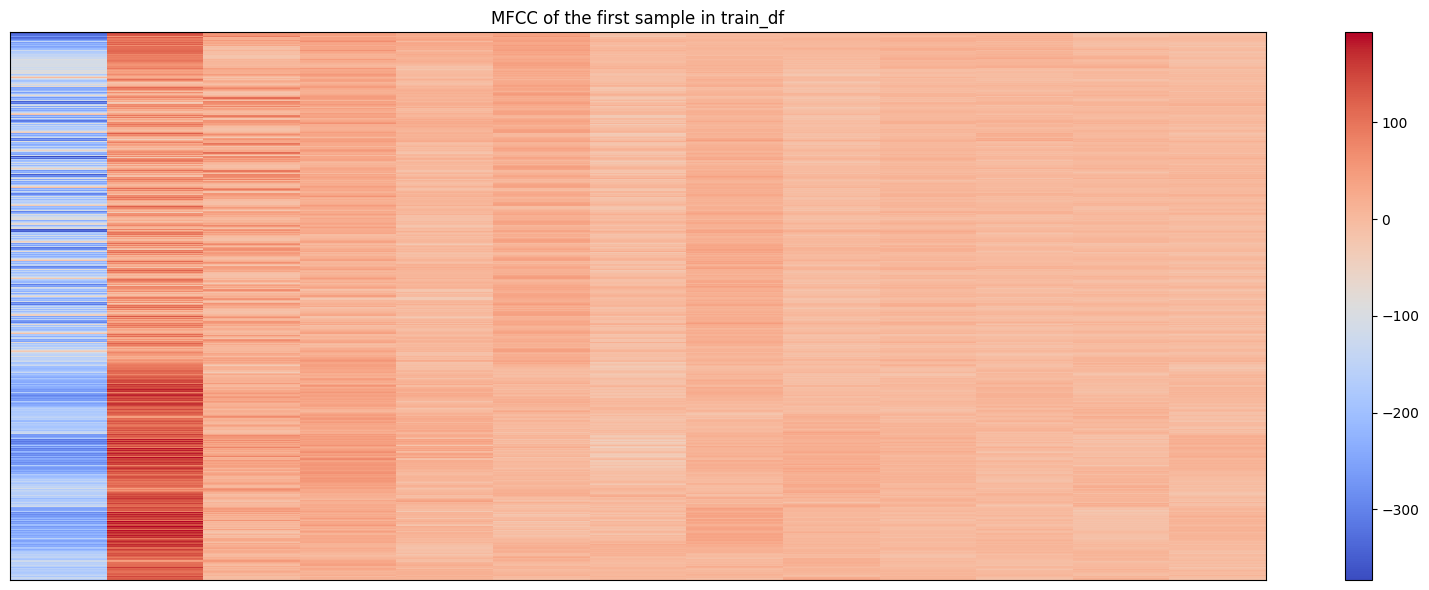

In [ ]:
# prompt: plot train_df mfcc column

import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Assuming train_df is already loaded and processed as in your provided code
# ... your existing code ...

# Plot the MFCC for the first sample in train_df
plt.figure(figsize=(16, 6))
librosa.display.specshow(np.transpose(train_df['mfcc'].iloc[0]))
plt.colorbar()
plt.title('MFCC of the first sample in train_df')
plt.tight_layout()
plt.show()

In [ ]:
train_df

file          genre  \
3135  fma_small/051/051261.mp3            Pop   
6059  fma_small/046/046078.mp3        Hip-Hop   
3701  fma_small/117/117612.mp3   Instrumental   
4583  fma_small/118/118505.mp3   Experimental   
1983  fma_small/128/128711.mp3           Rock   
...                        ...            ...   
1540  fma_small/139/139862.mp3   Experimental   
4499  fma_small/110/110451.mp3  International   
4468  fma_small/110/110653.mp3   Instrumental   
4909  fma_small/064/064592.mp3  International   
568   fma_small/069/069001.mp3   Experimental   

                                                    raw       sr  \
3135  [-3.7252903e-09, -1.1175871e-08, 0.0, -1.86264...  22050.0   
6059  [-0.0017032027, 0.0019398779, -0.032901645, -0...  22050.0   
3701  [-9.2303354e-10, -1.4587044e-09, -2.8250902e-1...  22050.0   
4583  [4.0745363e-10, 2.910383e-10, 6.9849193e-10, 2...  22050.0   
1983  [-1.8626451e-09, -9.313226e-10, -1.7695129e-08...  22050.0   
...                                                 ...      ...   
1540  [0.045261238, 0.080081634, 0.11224146, 0.07590...  22050.0   
4499  [-7.916242e-09, 8.8475645e-09, 2.7939677e-09, ...  22050.0   
4468  [0.0, -4.656613e-09, 2.7939677e-09, -2.3283064...  22050.0   
4909  [-5.2154064e-08, -5.5879354e-08, -4.4703484e-0...  22050.0   
568   [7.0937416e-09, 1.455057e-08, 1.0224789e-08, 5...  22050.0   

                                                   mfcc  \
3135  [[-308.95236, -165.32396, -132.03067, -132.232...   
6059  [[-81.64266, -14.655957, -7.521316, -11.1705, ...   
3701  [[-363.55472, -265.97504, -244.31306, -250.674...   
4583  [[-582.4073, -509.35822, -492.47388, -508.9029...   
1983  [[-329.50098, -119.876274, -49.42349, -51.8903...   
...                                                 ...   
1540  [[-99.42283, -41.6022, -27.80763, -25.487295, ...   
4499  [[-266.39798, -130.97435, -116.11321, -136.703...   
4468  [[-402.5168, -260.0842, -218.99542, -216.15176...   
4909  [[-286.61325, -140.1341, -47.53106, -10.619843...   
568   [[-301.5941, -166.23729, -130.21457, -126.7076...   

                                                 chroma                 tempo  \
3135  [[0.37114748, 0.4418225, 0.71450245, 0.6122071...  [117.45383522727273]   
6059  [[0.56065214, 1.0, 1.0, 1.0, 1.0, 0.52941275, ...          [172.265625]   
3701  [[0.35106325, 0.14504622, 0.15922183, 0.268165...          [86.1328125]   
4583  [[0.11148764, 0.03210852, 0.005365312, 0.00164...   [69.83741554054055]   
1983  [[0.8678135, 0.84442073, 0.62014794, 0.4765432...          [103.359375]   
...                                                 ...                   ...   
1540  [[0.48188233, 0.46649995, 0.39505243, 0.207003...         [92.28515625]   
4499  [[0.43458202, 0.6290135, 0.6245671, 0.52198976...           [95.703125]   
4468  [[0.5611873, 0.34375912, 0.19200522, 0.0407273...   [99.38401442307692]   
4909  [[0.74454284, 0.29671833, 0.25758496, 0.584477...  [112.34714673913044]   
568   [[0.88148636, 0.86588144, 0.69614357, 0.717991...   [99.38401442307692]   

                                               spectral  label  
3135  [[1786.0636685627635, 1860.7887629220827, 1843...      2  
6059  [[3113.0650624208624, 2826.492317302598, 2921....      4  
3701  [[1530.8890761507855, 1573.9462340621235, 1531...      7  
4583  [[1445.0446544673582, 1374.4916841305371, 1376...      0  
1983  [[1546.9483536976243, 1477.2817430129276, 1450...      6  
...                                                 ...    ...  
1540  [[3313.6149741661793, 3332.081768728108, 3599....      0  
4499  [[2879.477579134769, 2823.034255454462, 2830.4...      1  
4468  [[1435.071760035989, 1882.946436935208, 2750.1...      7  
4909  [[995.258275047142, 1158.585429617457, 1748.09...      1  
568   [[1613.8497156622436, 1872.235039987847, 2028....      0  

[5116 rows x 9 columns]

# Implementation

In [ ]:
log(f'Running experiments with normalized data? {NORMALIZE_DATA}')

Running experiments with normalized data? False


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f'Using device: {device}')

Using device: cuda


In [ ]:
# Custom Dataset para carregar as features
class FeatureDataset(Dataset):
    def __init__(self, df, features_col, transform=None):
        self.annotations = df
        self.transform = transform
        self.features_col = features_col

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        features = self.annotations.iloc[idx][self.features_col]
        features = torch.tensor(features, dtype=torch.float32)

        genre = self.annotations.iloc[idx]['label']
        label = torch.tensor(genre, dtype=torch.float32)

        if self.transform:
            features = self.transform(features)

        return features, label


In [ ]:
def get_data_loader(train_df, val_df, test_df, features_col, batch_size=32):
    # prepare the data loaders for pytorch
    train_dataset = FeatureDataset(df=train_df, features_col=features_col)
    val_dataset = FeatureDataset(df=val_df, features_col=features_col)
    test_dataset = FeatureDataset(df=test_df, features_col=features_col)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    return train_loader, val_loader, test_loader

## CNN

3 CNNs + FC + output

https://github.com/zwang-datascience/CRNN-TF/blob/master/1.ipynb

In [ ]:
log('Experiment: 3 CNNs + FC + output')

Experiment: 3 CNNs + FC + output


In [ ]:
# features_dim = {
#     'mfcc': 13,
#     'chroma': 12,
#     'tempo': 1,
#     'spectral': 1,
# }

features_dim = {}

for feature in name_of_features:
  features_dim[feature] = df[feature][0].shape[0]
log(f'Features dimensions: {features_dim}')

Features dimensions: {'raw': 1291, 'mfcc': 13, 'chroma': 12, 'spectral': 1}


In [ ]:
cnn_report = {}

In [ ]:
# CNN de Classificação
class CNN_Classifier(nn.Module):
    def __init__(self, n_dim, num_classes=8):
        super(CNN_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv1d(n_dim, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Linear(128 *  (1293 // (4 * 4 * 4)), 100),
            # nn.Linear(128 * 3 * 20, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x_flattened = x.view(x.size(0), -1)  # Achatar antes de passar pela camada fully connected
        out = self.fc(x_flattened)

        return out

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # X, y = X.unsqueeze(2).to(device), y.to(device)
            X, y = X.to(device), y.to(device).long()

            optimizer.zero_grad()

            outputs = model(X)
            loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device).long()

                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        log(f"Validation Loss: {avg_val_loss:.4f}")

        # Salvar o melhor modelo baseado na perda de validação
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            log(f"Model saved with validation loss: {best_val_loss:.4f}")


In [ ]:
# Função para avaliar o modelo e gerar o classification report
def evaluate_model(model, test_loader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    y_pred = []
    y_true = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    # Gerar o classification report
    log(classification_report(y_true, y_pred, target_names=test_df['genre'].unique(), output_dict=False))
    report = classification_report(y_true, y_pred, target_names=test_df['genre'].unique(), output_dict=True)

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=test_df['label'].unique())
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_df['genre'].unique())
    fig, ax = plt.subplots(figsize=(15,10))
    display(cmd.plot(ax=ax))

    return report

### For features: MFCC, Chroma, Spectral

--------------------------------------------------
Training model for feature: mfcc


Epoch 1/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 101.93it/s]


Validation Loss: 1.9044
Model saved with validation loss: 1.9044


Epoch 2/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 117.17it/s]


Validation Loss: 1.7977
Model saved with validation loss: 1.7977


Epoch 3/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 123.57it/s]


Validation Loss: 1.7497
Model saved with validation loss: 1.7497


Epoch 4/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 132.25it/s]


Validation Loss: 1.7185
Model saved with validation loss: 1.7185


Epoch 5/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.60it/s]


Validation Loss: 1.7044
Model saved with validation loss: 1.7044


Epoch 6/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.10it/s]


Validation Loss: 1.6836
Model saved with validation loss: 1.6836


Epoch 7/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 125.98it/s]


Validation Loss: 1.6743
Model saved with validation loss: 1.6743


Epoch 8/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.39it/s]


Validation Loss: 1.6736
Model saved with validation loss: 1.6736


Epoch 9/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.20it/s]


Validation Loss: 1.6478
Model saved with validation loss: 1.6478


Epoch 10/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.20it/s]


Validation Loss: 1.6636


Epoch 11/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.34it/s]


Validation Loss: 1.6381
Model saved with validation loss: 1.6381


Epoch 12/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 130.75it/s]


Validation Loss: 1.6236
Model saved with validation loss: 1.6236


Epoch 13/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 129.20it/s]


Validation Loss: 1.6159
Model saved with validation loss: 1.6159


Epoch 14/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 132.49it/s]


Validation Loss: 1.6133
Model saved with validation loss: 1.6133


Epoch 15/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 129.85it/s]


Validation Loss: 1.6004
Model saved with validation loss: 1.6004


Epoch 16/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.22it/s]


Validation Loss: 1.6054


Epoch 17/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.13it/s]


Validation Loss: 1.5895
Model saved with validation loss: 1.5895


Epoch 18/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 125.88it/s]


Validation Loss: 1.5839
Model saved with validation loss: 1.5839


Epoch 19/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 130.86it/s]


Validation Loss: 1.5945


Epoch 20/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 134.97it/s]


Validation Loss: 1.5767
Model saved with validation loss: 1.5767


Epoch 21/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.46it/s]


Validation Loss: 1.5805


Epoch 22/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 134.10it/s]


Validation Loss: 1.5738
Model saved with validation loss: 1.5738


Epoch 23/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 130.60it/s]


Validation Loss: 1.5663
Model saved with validation loss: 1.5663


Epoch 24/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.70it/s]


Validation Loss: 1.6004


Epoch 25/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.87it/s]


Validation Loss: 1.5653
Model saved with validation loss: 1.5653


Epoch 26/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 123.24it/s]


Validation Loss: 1.5707


Epoch 27/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 133.99it/s]


Validation Loss: 1.5622
Model saved with validation loss: 1.5622


Epoch 28/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 124.56it/s]


Validation Loss: 1.5622
Model saved with validation loss: 1.5622


Epoch 29/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 130.91it/s]


Validation Loss: 1.5542
Model saved with validation loss: 1.5542


Epoch 30/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.94it/s]


Validation Loss: 1.5591


Epoch 31/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 132.13it/s]


Validation Loss: 1.5424
Model saved with validation loss: 1.5424


Epoch 32/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.97it/s]


Validation Loss: 1.5398
Model saved with validation loss: 1.5398


Epoch 33/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 125.21it/s]


Validation Loss: 1.5459


Epoch 34/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.01it/s]


Validation Loss: 1.5362
Model saved with validation loss: 1.5362


Epoch 35/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.06it/s]


Validation Loss: 1.5336
Model saved with validation loss: 1.5336


Epoch 36/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 125.23it/s]


Validation Loss: 1.5425


Epoch 37/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 108.71it/s]


Validation Loss: 1.5456


Epoch 38/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 114.42it/s]


Validation Loss: 1.5346


Epoch 39/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 122.86it/s]


Validation Loss: 1.5398


Epoch 40/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.47it/s]


Validation Loss: 1.5306
Model saved with validation loss: 1.5306


Epoch 41/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.21it/s]


Validation Loss: 1.5358


Epoch 42/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 139.11it/s]


Validation Loss: 1.5214
Model saved with validation loss: 1.5214


Epoch 43/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.84it/s]


Validation Loss: 1.5476


Epoch 44/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 138.86it/s]


Validation Loss: 1.5266


Epoch 45/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 139.15it/s]


Validation Loss: 1.5391


Epoch 46/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 138.93it/s]


Validation Loss: 1.5357


Epoch 47/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 139.38it/s]


Validation Loss: 1.5319


Epoch 48/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 138.99it/s]


Validation Loss: 1.5219


Epoch 49/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.14it/s]


Validation Loss: 1.5311


Epoch 50/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.66it/s]
/tmp/ipykernel_3775670/2583734537.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Validation Loss: 1.5271
               precision    recall  f1-score   support

 Experimental       0.31      0.20      0.24       200
   Electronic       0.35      0.46      0.40       200
         Folk       0.27      0.25      0.26       200
      Hip-Hop       0.49      0.45      0.47       200
         Rock       0.57      0.62      0.59       199
          Pop       0.47      0.58      0.52       200
 Instrumental       0.59      0.51      0.55       200
International       0.45      0.48      0.47       200

     accuracy                           0.44      1599
    macro avg       0.44      0.44      0.44      1599
 weighted avg       0.44      0.44      0.44      1599



--------------------------------------------------
Training model for feature: chroma


Epoch 1/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.70it/s]


Validation Loss: 2.0005
Model saved with validation loss: 2.0005


Epoch 2/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 125.05it/s]


Validation Loss: 1.9287
Model saved with validation loss: 1.9287


Epoch 3/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.79it/s]


Validation Loss: 1.9212
Model saved with validation loss: 1.9212


Epoch 4/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 126.93it/s]


Validation Loss: 1.9067
Model saved with validation loss: 1.9067


Epoch 5/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.82it/s]


Validation Loss: 1.8957
Model saved with validation loss: 1.8957


Epoch 6/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.40it/s]


Validation Loss: 1.8709
Model saved with validation loss: 1.8709


Epoch 7/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.68it/s]


Validation Loss: 1.8588
Model saved with validation loss: 1.8588


Epoch 8/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.14it/s]


Validation Loss: 1.8252
Model saved with validation loss: 1.8252


Epoch 9/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.62it/s]


Validation Loss: 1.8016
Model saved with validation loss: 1.8016


Epoch 10/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.59it/s]


Validation Loss: 1.7840
Model saved with validation loss: 1.7840


Epoch 11/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.97it/s]


Validation Loss: 1.7800
Model saved with validation loss: 1.7800


Epoch 12/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.46it/s]


Validation Loss: 1.7653
Model saved with validation loss: 1.7653


Epoch 13/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 134.49it/s]


Validation Loss: 1.7650
Model saved with validation loss: 1.7650


Epoch 14/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.82it/s]


Validation Loss: 1.7706


Epoch 15/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.57it/s]


Validation Loss: 1.7511
Model saved with validation loss: 1.7511


Epoch 16/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.87it/s]


Validation Loss: 1.7459
Model saved with validation loss: 1.7459


Epoch 17/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.88it/s]


Validation Loss: 1.7537


Epoch 18/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.16it/s]


Validation Loss: 1.7418
Model saved with validation loss: 1.7418


Epoch 19/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 130.15it/s]


Validation Loss: 1.7348
Model saved with validation loss: 1.7348


Epoch 20/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 131.10it/s]


Validation Loss: 1.7361


Epoch 21/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.04it/s]


Validation Loss: 1.7581


Epoch 22/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.25it/s]


Validation Loss: 1.7353


Epoch 23/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.15it/s]


Validation Loss: 1.7306
Model saved with validation loss: 1.7306


Epoch 24/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 127.95it/s]


Validation Loss: 1.7320


Epoch 25/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.54it/s]


Validation Loss: 1.7355


Epoch 26/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.97it/s]


Validation Loss: 1.7194
Model saved with validation loss: 1.7194


Epoch 27/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 133.33it/s]


Validation Loss: 1.7092
Model saved with validation loss: 1.7092


Epoch 28/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 134.14it/s]


Validation Loss: 1.7095


Epoch 29/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.08it/s]


Validation Loss: 1.7023
Model saved with validation loss: 1.7023


Epoch 30/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 128.62it/s]


Validation Loss: 1.7084


Epoch 31/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.88it/s]


Validation Loss: 1.6979
Model saved with validation loss: 1.6979


Epoch 32/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 133.05it/s]


Validation Loss: 1.7100


Epoch 33/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.23it/s]


Validation Loss: 1.7015


Epoch 34/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.51it/s]


Validation Loss: 1.7340


Epoch 35/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.19it/s]


Validation Loss: 1.7003


Epoch 36/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.33it/s]


Validation Loss: 1.6912
Model saved with validation loss: 1.6912


Epoch 37/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.92it/s]


Validation Loss: 1.7788


Epoch 38/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.62it/s]


Validation Loss: 1.7080


Epoch 39/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.35it/s]


Validation Loss: 1.6932


Epoch 40/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.38it/s]


Validation Loss: 1.6885
Model saved with validation loss: 1.6885


Epoch 41/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.45it/s]


Validation Loss: 1.7156


Epoch 42/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.39it/s]


Validation Loss: 1.6907


Epoch 43/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.76it/s]


Validation Loss: 1.6908


Epoch 44/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 136.68it/s]


Validation Loss: 1.6886


Epoch 45/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.58it/s]


Validation Loss: 1.6976


Epoch 46/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.51it/s]


Validation Loss: 1.6893


Epoch 47/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.34it/s]


Validation Loss: 1.6778
Model saved with validation loss: 1.6778


Epoch 48/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 135.92it/s]


Validation Loss: 1.7028


Epoch 49/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.66it/s]


Validation Loss: 1.6940


Epoch 50/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 137.81it/s]
/tmp/ipykernel_3775670/2583734537.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Validation Loss: 1.7019
               precision    recall  f1-score   support

 Experimental       0.37      0.10      0.15       200
   Electronic       0.40      0.42      0.41       200
         Folk       0.26      0.16      0.20       200
      Hip-Hop       0.37      0.36      0.36       200
         Rock       0.48      0.60      0.53       199
          Pop       0.38      0.49      0.43       200
 Instrumental       0.41      0.57      0.47       200
International       0.47      0.55      0.51       200

     accuracy                           0.41      1599
    macro avg       0.39      0.41      0.38      1599
 weighted avg       0.39      0.41      0.38      1599



--------------------------------------------------
Training model for feature: spectral


Epoch 1/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 145.17it/s]


Validation Loss: 12.1932
Model saved with validation loss: 12.1932


Epoch 2/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.69it/s]


Validation Loss: 9.3253
Model saved with validation loss: 9.3253


Epoch 3/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.43it/s]


Validation Loss: 8.3802
Model saved with validation loss: 8.3802


Epoch 4/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 147.90it/s]


Validation Loss: 7.7241
Model saved with validation loss: 7.7241


Epoch 5/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 146.27it/s]


Validation Loss: 6.8278
Model saved with validation loss: 6.8278


Epoch 6/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.49it/s]


Validation Loss: 6.5697
Model saved with validation loss: 6.5697


Epoch 7/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.84it/s]


Validation Loss: 6.8192


Epoch 8/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.95it/s]


Validation Loss: 6.7236


Epoch 9/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.00it/s]


Validation Loss: 5.8636
Model saved with validation loss: 5.8636


Epoch 10/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.44it/s]


Validation Loss: 5.6164
Model saved with validation loss: 5.6164


Epoch 11/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.35it/s]


Validation Loss: 5.3968
Model saved with validation loss: 5.3968


Epoch 12/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 154.75it/s]


Validation Loss: 5.2934
Model saved with validation loss: 5.2934


Epoch 13/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.13it/s]


Validation Loss: 5.2707
Model saved with validation loss: 5.2707


Epoch 14/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.54it/s]


Validation Loss: 5.3536


Epoch 15/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.51it/s]


Validation Loss: 5.2683
Model saved with validation loss: 5.2683


Epoch 16/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.63it/s]


Validation Loss: 4.7926
Model saved with validation loss: 4.7926


Epoch 17/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 147.89it/s]


Validation Loss: 4.9806


Epoch 18/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.18it/s]


Validation Loss: 4.8047


Epoch 19/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.41it/s]


Validation Loss: 4.9604


Epoch 20/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.32it/s]


Validation Loss: 4.6663
Model saved with validation loss: 4.6663


Epoch 21/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.91it/s]


Validation Loss: 4.5833
Model saved with validation loss: 4.5833


Epoch 22/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.39it/s]


Validation Loss: 4.6346


Epoch 23/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.96it/s]


Validation Loss: 4.5607
Model saved with validation loss: 4.5607


Epoch 24/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.55it/s]


Validation Loss: 4.3475
Model saved with validation loss: 4.3475


Epoch 25/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.17it/s]


Validation Loss: 4.6505


Epoch 26/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.32it/s]


Validation Loss: 4.4721


Epoch 27/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.53it/s]


Validation Loss: 4.3175
Model saved with validation loss: 4.3175


Epoch 28/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.50it/s]


Validation Loss: 4.6465


Epoch 29/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.94it/s]


Validation Loss: 4.3303


Epoch 30/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.81it/s]


Validation Loss: 4.0772
Model saved with validation loss: 4.0772


Epoch 31/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.48it/s]


Validation Loss: 4.3024


Epoch 32/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.63it/s]


Validation Loss: 4.2438


Epoch 33/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.37it/s]


Validation Loss: 4.1421


Epoch 34/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.93it/s]


Validation Loss: 4.1237


Epoch 35/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.75it/s]


Validation Loss: 4.1077


Epoch 36/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.03it/s]


Validation Loss: 4.0557
Model saved with validation loss: 4.0557


Epoch 37/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.86it/s]


Validation Loss: 3.9581
Model saved with validation loss: 3.9581


Epoch 38/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.04it/s]


Validation Loss: 4.1038


Epoch 39/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.67it/s]


Validation Loss: 4.0184


Epoch 40/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.04it/s]


Validation Loss: 4.3104


Epoch 41/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.63it/s]


Validation Loss: 4.0194


Epoch 42/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 146.82it/s]


Validation Loss: 4.1687


Epoch 43/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.68it/s]


Validation Loss: 3.9279
Model saved with validation loss: 3.9279


Epoch 44/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.92it/s]


Validation Loss: 4.0447


Epoch 45/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.95it/s]


Validation Loss: 3.7944
Model saved with validation loss: 3.7944


Epoch 46/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.60it/s]


Validation Loss: 3.8105


Epoch 47/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.75it/s]


Validation Loss: 3.8349


Epoch 48/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.86it/s]


Validation Loss: 4.1607


Epoch 49/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.33it/s]


Validation Loss: 3.9160


Epoch 50/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.38it/s]
/tmp/ipykernel_3775670/2583734537.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Validation Loss: 3.9209
               precision    recall  f1-score   support

 Experimental       0.19      0.26      0.22       200
   Electronic       0.22      0.18      0.20       200
         Folk       0.16      0.15      0.15       200
      Hip-Hop       0.28      0.31      0.29       200
         Rock       0.36      0.31      0.33       199
          Pop       0.25      0.28      0.27       200
 Instrumental       0.26      0.27      0.26       200
International       0.24      0.16      0.19       200

     accuracy                           0.24      1599
    macro avg       0.24      0.24      0.24      1599
 weighted avg       0.24      0.24      0.24      1599



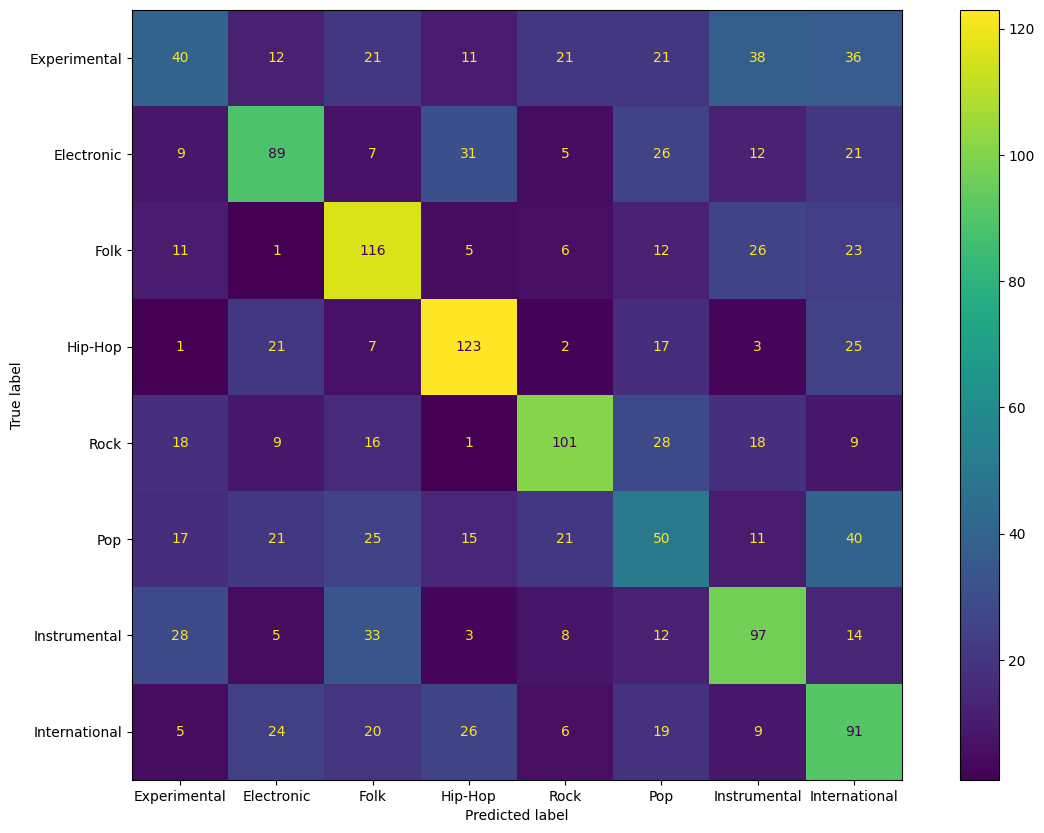

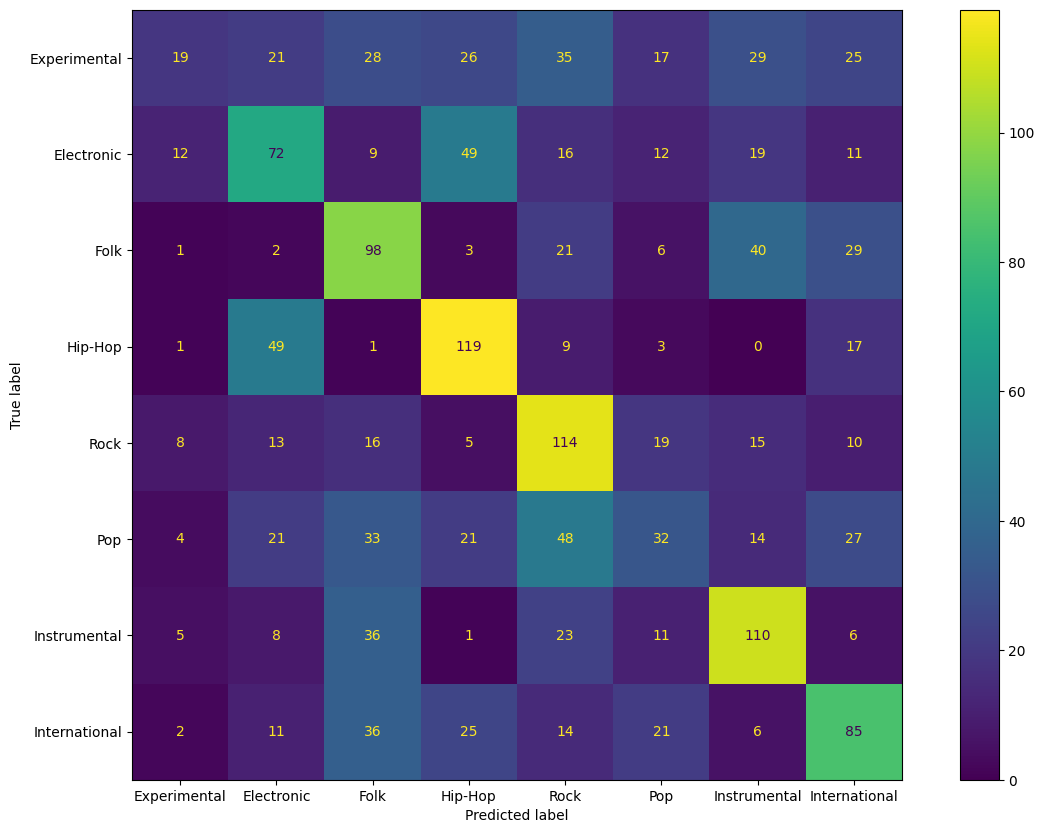

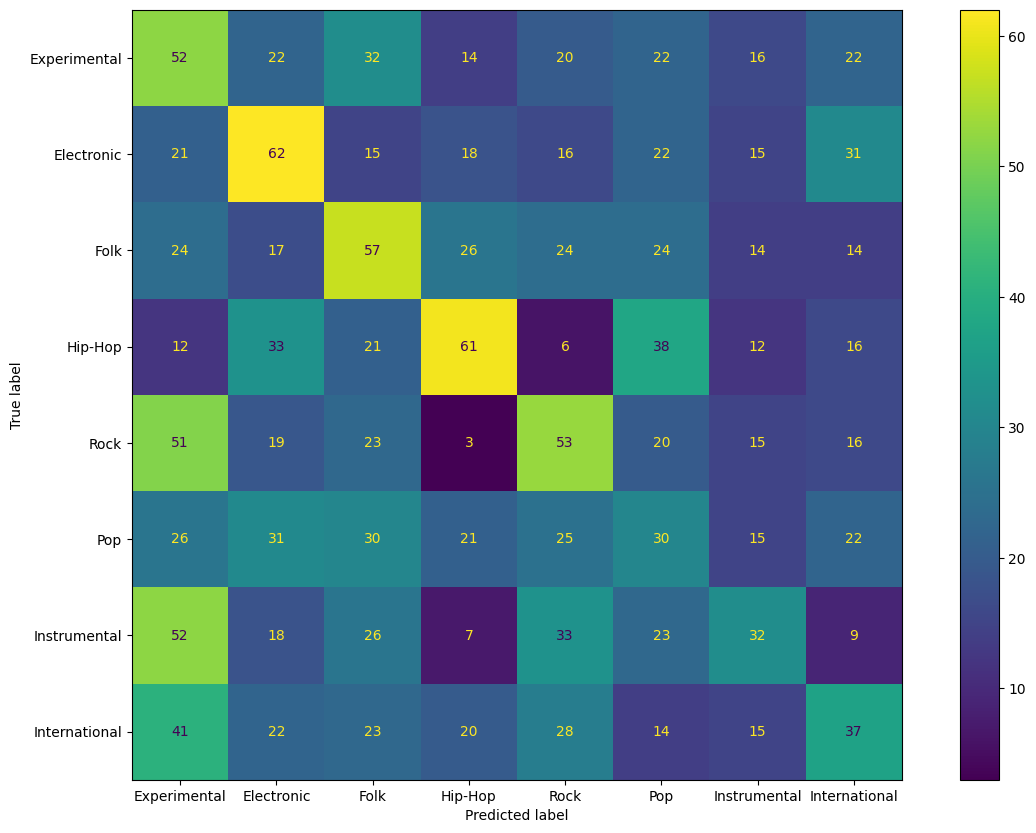

In [ ]:
num_classes = len(df['genre'].unique())
criterion = nn.CrossEntropyLoss()

features_lr = {
    'mfcc': 0.00001,
    'chroma': 0.0001,
    'spectral': 0.00001,
}

# for each feature, train a model and evaluate it
for feature in ['mfcc', 'chroma', 'spectral']:
    log(f"-"*50)
    log(f"Training model for feature: {feature}")
    model = CNN_Classifier(n_dim=features_dim[feature], num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=features_lr[feature])

    train_loader, val_loader, test_loader = get_data_loader(train_df, val_df, test_df, feature)

    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50)
    model.load_state_dict(torch.load('best_model.pth'))

    # Avaliar o modelo
    cnn_report[feature] = evaluate_model(model, test_loader, device)

### For raw data

In [ ]:
# CNN de Classificação
class CNN_Raw_Classifier(nn.Module):
    def __init__(self, n_dim=1, input_length=1291, num_classes=8):
        super(CNN_Raw_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv1d(n_dim, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        encoder_output_size = input_length // (4 * 4 * 4)  # Division by pooling layers
        flattened_size = 128 * encoder_output_size

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder(x)
        x_flattened = x.view(x.size(0), -1)  # Achatar antes de passar pela camada fully connected
        out = self.fc(x_flattened)

        return out

--------------------------------------------------
Training model for feature: raw


Epoch 1/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.57it/s]


Validation Loss: 2.0697
Model saved with validation loss: 2.0697


Epoch 2/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.08it/s]


Validation Loss: 2.0373
Model saved with validation loss: 2.0373


Epoch 3/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.42it/s]


Validation Loss: 2.0262
Model saved with validation loss: 2.0262


Epoch 4/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.57it/s]


Validation Loss: 1.9970
Model saved with validation loss: 1.9970


Epoch 5/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.40it/s]


Validation Loss: 1.9843
Model saved with validation loss: 1.9843


Epoch 6/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.49it/s]


Validation Loss: 1.9733
Model saved with validation loss: 1.9733


Epoch 7/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.58it/s]


Validation Loss: 1.9671
Model saved with validation loss: 1.9671


Epoch 8/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.87it/s]


Validation Loss: 1.9572
Model saved with validation loss: 1.9572


Epoch 9/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 149.69it/s]


Validation Loss: 1.9525
Model saved with validation loss: 1.9525


Epoch 10/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.43it/s]


Validation Loss: 1.9493
Model saved with validation loss: 1.9493


Epoch 11/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.14it/s]


Validation Loss: 1.9437
Model saved with validation loss: 1.9437


Epoch 12/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.86it/s]


Validation Loss: 1.9424
Model saved with validation loss: 1.9424


Epoch 13/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 143.60it/s]


Validation Loss: 1.9423
Model saved with validation loss: 1.9423


Epoch 14/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.21it/s]


Validation Loss: 1.9364
Model saved with validation loss: 1.9364


Epoch 15/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.51it/s]


Validation Loss: 1.9459


Epoch 16/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.41it/s]


Validation Loss: 1.9336
Model saved with validation loss: 1.9336


Epoch 17/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 141.47it/s]


Validation Loss: 1.9303
Model saved with validation loss: 1.9303


Epoch 18/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.70it/s]


Validation Loss: 1.9312


Epoch 19/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.55it/s]


Validation Loss: 1.9310


Epoch 20/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.33it/s]


Validation Loss: 1.9285
Model saved with validation loss: 1.9285


Epoch 21/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 150.54it/s]


Validation Loss: 1.9315


Epoch 22/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.01it/s]


Validation Loss: 1.9241
Model saved with validation loss: 1.9241


Epoch 23/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.27it/s]


Validation Loss: 1.9365


Epoch 24/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.58it/s]


Validation Loss: 1.9276


Epoch 25/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.87it/s]


Validation Loss: 1.9263


Epoch 26/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.84it/s]


Validation Loss: 1.9239
Model saved with validation loss: 1.9239


Epoch 27/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.75it/s]


Validation Loss: 1.9223
Model saved with validation loss: 1.9223


Epoch 28/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 148.73it/s]


Validation Loss: 1.9198
Model saved with validation loss: 1.9198


Epoch 29/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.54it/s]


Validation Loss: 1.9209


Epoch 30/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.54it/s]


Validation Loss: 1.9228


Epoch 31/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.41it/s]


Validation Loss: 1.9165
Model saved with validation loss: 1.9165


Epoch 32/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 151.09it/s]


Validation Loss: 1.9173


Epoch 33/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.60it/s]


Validation Loss: 1.9209


Epoch 34/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.85it/s]


Validation Loss: 1.9267


Epoch 35/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.26it/s]


Validation Loss: 1.9298


Epoch 36/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.22it/s]


Validation Loss: 1.9380


Epoch 37/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.16it/s]


Validation Loss: 1.9220


Epoch 38/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.54it/s]


Validation Loss: 1.9231


Epoch 39/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.14it/s]


Validation Loss: 1.9280


Epoch 40/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 152.77it/s]


Validation Loss: 1.9397


Epoch 41/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.15it/s]


Validation Loss: 1.9270


Epoch 42/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.20it/s]


Validation Loss: 1.9294


Epoch 43/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.13it/s]


Validation Loss: 1.9360


Epoch 44/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.23it/s]


Validation Loss: 1.9263


Epoch 45/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.50it/s]


Validation Loss: 1.9327


Epoch 46/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.58it/s]


Validation Loss: 1.9490


Epoch 47/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.52it/s]


Validation Loss: 1.9506


Epoch 48/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.33it/s]


Validation Loss: 1.9454


Epoch 49/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.65it/s]


Validation Loss: 1.9519


Epoch 50/50: 100%|█████████████████████████████████████████████████████| 160/160 [00:01<00:00, 153.68it/s]
/tmp/ipykernel_3775670/2018173150.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Validation Loss: 1.9663
               precision    recall  f1-score   support

 Experimental       0.24      0.18      0.21       200
   Electronic       0.31      0.23      0.26       200
         Folk       0.24      0.05      0.08       200
      Hip-Hop       0.29      0.23      0.26       200
         Rock       0.35      0.27      0.30       199
          Pop       0.27      0.42      0.33       200
 Instrumental       0.30      0.47      0.37       200
International       0.26      0.40      0.31       200

     accuracy                           0.28      1599
    macro avg       0.28      0.28      0.26      1599
 weighted avg       0.28      0.28      0.26      1599



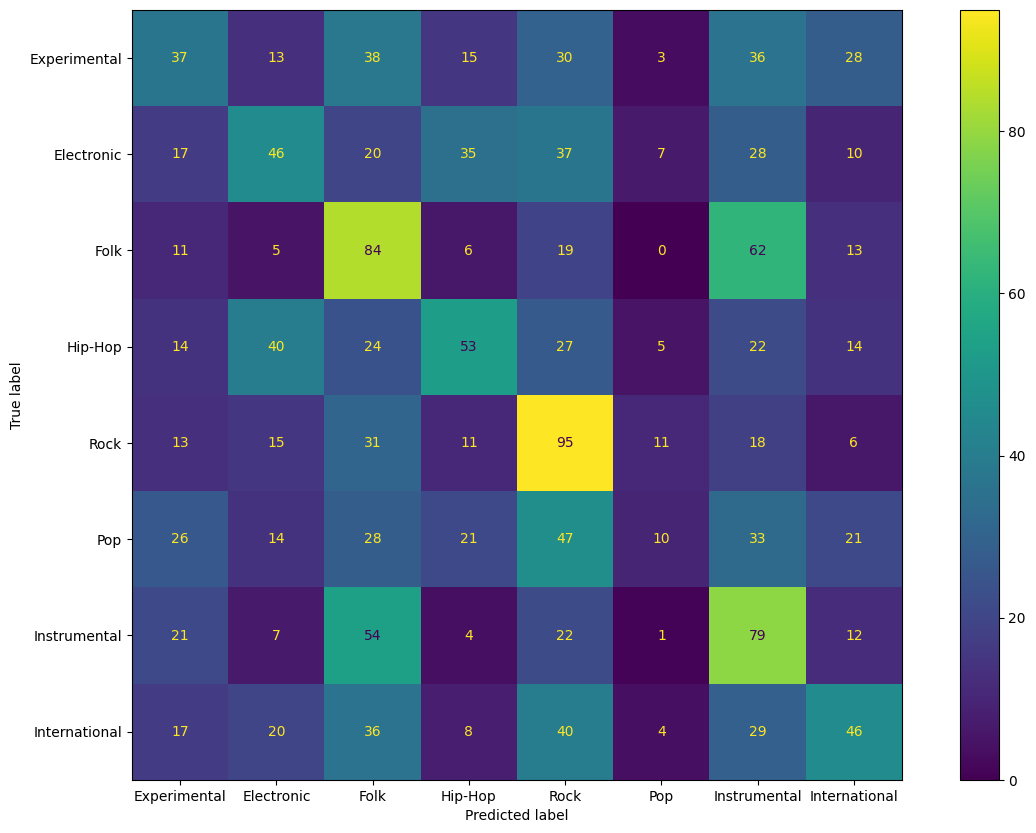

In [ ]:
num_classes = len(df['genre'].unique())
criterion = nn.CrossEntropyLoss()

# for raw feature, train a model and evaluate it
feature = 'raw'

log(f"-"*50)
log(f"Training model for feature: {feature}")
model = CNN_Raw_Classifier(n_dim=1, input_length=1291, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader, val_loader, test_loader = get_data_loader(train_df, val_df, test_df, feature)

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50)
model.load_state_dict(torch.load('best_model.pth'))

# Avaliar o modelo
cnn_report['raw'] = evaluate_model(model, test_loader, device)

In [ ]:
# save cnn_report
cnn_report_df = pd.DataFrame(cnn_report)
cnn_report_df.to_pickle('cnn_report.pkl')

## CRNN

In [ ]:
log('Experiment: CRNN')

In [ ]:
crnn_report = {}

In [ ]:
# CNN de Classificação
class CNN_GRU_Classifier(nn.Module):
    def __init__(self, n_dim, num_classes=8):
        super(CNN_GRU_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv1d(n_dim, 64, kernel_size=3, stride=1, padding=1),  # (batch, 64, 1291)
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4),  # (batch, 64, 322)

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 322)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4),  # (batch, 128, 80)

            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 80)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4)  # (batch, 128, 20)
        )

        self.gru = nn.GRU(input_size=128, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 2, 64),  # Bidirectional GRU output (32*2)
            nn.ELU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(0, 2, 1) # Rearranja para (batch_size, final_length, 128)

        gru_out, _ = self.gru(x)  # Saída: (batch_size, final_length, hidden_size * 2)
        gru_out = gru_out[:, -1, :]  # Considera apenas a última saída (batch_size, hidden_size * 2)

        # Classificação
        out = self.fc(gru_out)  # (batch_size, num_classes)
        return out

### For features: MFCC, Chroma, Spectral Centroid

--------------------------------------------------
Training model for feature: mfcc


Epoch 1/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.49it/s]


Validation Loss: 1.8139
Model saved with validation loss: 1.8139


Epoch 2/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.42it/s]


Validation Loss: 1.7410
Model saved with validation loss: 1.7410


Epoch 3/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.40it/s]


Validation Loss: 1.6907
Model saved with validation loss: 1.6907


Epoch 4/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.72it/s]


Validation Loss: 1.6589
Model saved with validation loss: 1.6589


Epoch 5/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.87it/s]


Validation Loss: 1.6235
Model saved with validation loss: 1.6235


Epoch 6/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.15it/s]


Validation Loss: 1.6041
Model saved with validation loss: 1.6041


Epoch 7/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.19it/s]


Validation Loss: 1.5866
Model saved with validation loss: 1.5866


Epoch 8/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.68it/s]


Validation Loss: 1.5641
Model saved with validation loss: 1.5641


Epoch 9/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.26it/s]


Validation Loss: 1.5530
Model saved with validation loss: 1.5530


Epoch 10/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.33it/s]


Validation Loss: 1.5297
Model saved with validation loss: 1.5297


Epoch 11/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.75it/s]


Validation Loss: 1.5180
Model saved with validation loss: 1.5180


Epoch 12/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.98it/s]


Validation Loss: 1.5004
Model saved with validation loss: 1.5004


Epoch 13/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.72it/s]


Validation Loss: 1.4974
Model saved with validation loss: 1.4974


Epoch 14/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.81it/s]


Validation Loss: 1.4804
Model saved with validation loss: 1.4804


Epoch 15/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.97it/s]


Validation Loss: 1.4902


Epoch 16/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.91it/s]


Validation Loss: 1.4731
Model saved with validation loss: 1.4731


Epoch 17/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.16it/s]


Validation Loss: 1.4609
Model saved with validation loss: 1.4609


Epoch 18/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.86it/s]


Validation Loss: 1.4789


Epoch 19/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.87it/s]


Validation Loss: 1.4489
Model saved with validation loss: 1.4489


Epoch 20/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.78it/s]


Validation Loss: 1.4573


Epoch 21/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.09it/s]


Validation Loss: 1.4745


Epoch 22/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.20it/s]


Validation Loss: 1.4619


Epoch 23/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.93it/s]


Validation Loss: 1.4579


Epoch 24/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.11it/s]


Validation Loss: 1.5089


Epoch 25/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.44it/s]


Validation Loss: 1.4722


Epoch 26/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.91it/s]


Validation Loss: 1.4547


Epoch 27/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.83it/s]


Validation Loss: 1.4577


Epoch 28/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.93it/s]


Validation Loss: 1.4765


Epoch 29/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.97it/s]


Validation Loss: 1.5174


Epoch 30/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.21it/s]


Validation Loss: 1.4718


Epoch 31/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.70it/s]


Validation Loss: 1.4566


Epoch 32/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.90it/s]


Validation Loss: 1.4962


Epoch 33/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.14it/s]


Validation Loss: 1.5078


Epoch 34/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.87it/s]


Validation Loss: 1.5015


Epoch 35/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.53it/s]


Validation Loss: 1.4978


Epoch 36/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.08it/s]


Validation Loss: 1.5417


Epoch 37/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.87it/s]


Validation Loss: 1.5854


Epoch 38/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.05it/s]


Validation Loss: 1.5099


Epoch 39/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.02it/s]


Validation Loss: 1.5112


Epoch 40/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.00it/s]


Validation Loss: 1.5912


Epoch 41/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.03it/s]


Validation Loss: 1.6028


Epoch 42/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.88it/s]


Validation Loss: 1.5473


Epoch 43/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.88it/s]


Validation Loss: 1.6199


Epoch 44/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.00it/s]


Validation Loss: 1.6488


Epoch 45/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.36it/s]


Validation Loss: 1.6077


Epoch 46/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.10it/s]


Validation Loss: 1.5833


Epoch 47/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.11it/s]


Validation Loss: 1.6512


Epoch 48/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.50it/s]


Validation Loss: 1.6438


Epoch 49/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.89it/s]


Validation Loss: 1.6810


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.66it/s]


Validation Loss: 1.6868


/tmp/ipykernel_3775670/1112210371.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


               precision    recall  f1-score   support

 Experimental       0.37      0.24      0.29       200
   Electronic       0.42      0.53      0.47       200
         Folk       0.43      0.15      0.23       200
      Hip-Hop       0.47      0.61      0.53       200
         Rock       0.72      0.65      0.68       199
          Pop       0.49      0.67      0.56       200
 Instrumental       0.55      0.65      0.60       200
International       0.50      0.48      0.49       200

     accuracy                           0.50      1599
    macro avg       0.49      0.50      0.48      1599
 weighted avg       0.49      0.50      0.48      1599



--------------------------------------------------
Training model for feature: chroma


Epoch 1/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 69.22it/s]


Validation Loss: 1.9080
Model saved with validation loss: 1.9080


Epoch 2/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.29it/s]


Validation Loss: 1.8531
Model saved with validation loss: 1.8531


Epoch 3/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.65it/s]


Validation Loss: 1.8251
Model saved with validation loss: 1.8251


Epoch 4/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.14it/s]


Validation Loss: 1.8046
Model saved with validation loss: 1.8046


Epoch 5/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.79it/s]


Validation Loss: 1.7944
Model saved with validation loss: 1.7944


Epoch 6/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.53it/s]


Validation Loss: 1.7736
Model saved with validation loss: 1.7736


Epoch 7/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.55it/s]


Validation Loss: 1.7617
Model saved with validation loss: 1.7617


Epoch 8/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.69it/s]


Validation Loss: 1.7477
Model saved with validation loss: 1.7477


Epoch 9/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.32it/s]


Validation Loss: 1.7405
Model saved with validation loss: 1.7405


Epoch 10/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.83it/s]


Validation Loss: 1.7237
Model saved with validation loss: 1.7237


Epoch 11/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.86it/s]


Validation Loss: 1.7242


Epoch 12/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.36it/s]


Validation Loss: 1.7024
Model saved with validation loss: 1.7024


Epoch 13/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.67it/s]


Validation Loss: 1.6955
Model saved with validation loss: 1.6955


Epoch 14/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.80it/s]


Validation Loss: 1.6981


Epoch 15/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.04it/s]


Validation Loss: 1.6914
Model saved with validation loss: 1.6914


Epoch 16/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.32it/s]


Validation Loss: 1.7296


Epoch 17/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.15it/s]


Validation Loss: 1.7361


Epoch 18/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.70it/s]


Validation Loss: 1.7440


Epoch 19/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.02it/s]


Validation Loss: 1.7472


Epoch 20/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.87it/s]


Validation Loss: 1.7601


Epoch 21/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.66it/s]


Validation Loss: 1.7708


Epoch 22/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.90it/s]


Validation Loss: 1.7937


Epoch 23/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.88it/s]


Validation Loss: 1.8000


Epoch 24/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.35it/s]


Validation Loss: 1.8519


Epoch 25/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.74it/s]


Validation Loss: 1.8779


Epoch 26/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.26it/s]


Validation Loss: 1.9104


Epoch 27/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.55it/s]


Validation Loss: 1.9402


Epoch 28/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.04it/s]


Validation Loss: 1.9625


Epoch 29/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.24it/s]


Validation Loss: 1.9770


Epoch 30/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.96it/s]


Validation Loss: 2.0676


Epoch 31/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 70.90it/s]


Validation Loss: 2.0646


Epoch 32/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.15it/s]


Validation Loss: 2.1066


Epoch 33/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.07it/s]


Validation Loss: 2.2140


Epoch 34/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.40it/s]


Validation Loss: 2.2697


Epoch 35/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.43it/s]


Validation Loss: 2.2641


Epoch 36/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.89it/s]


Validation Loss: 2.3075


Epoch 37/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.08it/s]


Validation Loss: 2.3195


Epoch 38/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.23it/s]


Validation Loss: 2.6224


Epoch 39/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.08it/s]


Validation Loss: 2.3588


Epoch 40/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.19it/s]


Validation Loss: 2.4629


Epoch 41/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.57it/s]


Validation Loss: 2.6074


Epoch 42/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.65it/s]


Validation Loss: 2.5641


Epoch 43/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.40it/s]


Validation Loss: 2.6542


Epoch 44/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.33it/s]


Validation Loss: 2.5851


Epoch 45/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.04it/s]


Validation Loss: 2.6567


Epoch 46/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.71it/s]


Validation Loss: 2.6961


Epoch 47/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.84it/s]


Validation Loss: 2.7631


Epoch 48/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.21it/s]


Validation Loss: 2.7892


Epoch 49/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.11it/s]


Validation Loss: 2.8737


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.27it/s]


Validation Loss: 3.1831


/tmp/ipykernel_3775670/1112210371.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


               precision    recall  f1-score   support

 Experimental       0.27      0.17      0.21       200
   Electronic       0.40      0.32      0.35       200
         Folk       0.27      0.10      0.14       200
      Hip-Hop       0.32      0.29      0.31       200
         Rock       0.47      0.58      0.52       199
          Pop       0.36      0.46      0.41       200
 Instrumental       0.39      0.47      0.42       200
International       0.37      0.57      0.45       200

     accuracy                           0.37      1599
    macro avg       0.36      0.37      0.35      1599
 weighted avg       0.36      0.37      0.35      1599



--------------------------------------------------
Training model for feature: spectral


Epoch 1/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.71it/s]


Validation Loss: 1.8812
Model saved with validation loss: 1.8812


Epoch 2/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.18it/s]


Validation Loss: 1.8397
Model saved with validation loss: 1.8397


Epoch 3/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.14it/s]


Validation Loss: 1.8170
Model saved with validation loss: 1.8170


Epoch 4/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.68it/s]


Validation Loss: 1.7963
Model saved with validation loss: 1.7963


Epoch 5/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.15it/s]


Validation Loss: 1.7805
Model saved with validation loss: 1.7805


Epoch 6/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.62it/s]


Validation Loss: 1.7688
Model saved with validation loss: 1.7688


Epoch 7/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 77.88it/s]


Validation Loss: 1.7658
Model saved with validation loss: 1.7658


Epoch 8/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.22it/s]


Validation Loss: 1.7520
Model saved with validation loss: 1.7520


Epoch 9/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.20it/s]


Validation Loss: 1.7408
Model saved with validation loss: 1.7408


Epoch 10/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.52it/s]


Validation Loss: 1.7312
Model saved with validation loss: 1.7312


Epoch 11/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.80it/s]


Validation Loss: 1.7210
Model saved with validation loss: 1.7210


Epoch 12/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.05it/s]


Validation Loss: 1.7160
Model saved with validation loss: 1.7160


Epoch 13/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.46it/s]


Validation Loss: 1.7058
Model saved with validation loss: 1.7058


Epoch 14/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.25it/s]


Validation Loss: 1.7085


Epoch 15/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.04it/s]


Validation Loss: 1.7094


Epoch 16/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.88it/s]


Validation Loss: 1.6950
Model saved with validation loss: 1.6950


Epoch 17/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.97it/s]


Validation Loss: 1.7109


Epoch 18/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.50it/s]


Validation Loss: 1.7009


Epoch 19/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.62it/s]


Validation Loss: 1.7183


Epoch 20/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.41it/s]


Validation Loss: 1.6785
Model saved with validation loss: 1.6785


Epoch 21/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 71.73it/s]


Validation Loss: 1.6849


Epoch 22/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.62it/s]


Validation Loss: 1.7037


Epoch 23/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.55it/s]


Validation Loss: 1.6780
Model saved with validation loss: 1.6780


Epoch 24/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.51it/s]


Validation Loss: 1.6985


Epoch 25/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.54it/s]


Validation Loss: 1.7262


Epoch 26/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.59it/s]


Validation Loss: 1.6999


Epoch 27/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.80it/s]


Validation Loss: 1.7245


Epoch 28/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.60it/s]


Validation Loss: 1.6871


Epoch 29/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.84it/s]


Validation Loss: 1.7281


Epoch 30/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.34it/s]


Validation Loss: 1.7500


Epoch 31/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.45it/s]


Validation Loss: 1.7886


Epoch 32/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.21it/s]


Validation Loss: 1.7392


Epoch 33/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.82it/s]


Validation Loss: 1.7291


Epoch 34/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.41it/s]


Validation Loss: 1.7093


Epoch 35/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.80it/s]


Validation Loss: 1.7362


Epoch 36/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.83it/s]


Validation Loss: 1.7684


Epoch 37/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.38it/s]


Validation Loss: 1.7438


Epoch 38/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.45it/s]


Validation Loss: 1.8092


Epoch 39/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.47it/s]


Validation Loss: 1.7405


Epoch 40/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.36it/s]


Validation Loss: 1.7684


Epoch 41/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.55it/s]


Validation Loss: 1.8438


Epoch 42/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.65it/s]


Validation Loss: 1.7488


Epoch 43/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.38it/s]


Validation Loss: 1.8450


Epoch 44/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.52it/s]


Validation Loss: 1.8162


Epoch 45/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.43it/s]


Validation Loss: 1.7877


Epoch 46/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.58it/s]


Validation Loss: 1.8881


Epoch 47/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.72it/s]


Validation Loss: 1.8564


Epoch 48/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.73it/s]


Validation Loss: 1.9291


Epoch 49/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 78.66it/s]


Validation Loss: 1.8954


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.60it/s]


Validation Loss: 1.8596


/tmp/ipykernel_3775670/1112210371.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


               precision    recall  f1-score   support

 Experimental       0.32      0.20      0.25       200
   Electronic       0.23      0.26      0.25       200
         Folk       0.40      0.14      0.21       200
      Hip-Hop       0.42      0.35      0.38       200
         Rock       0.53      0.74      0.61       199
          Pop       0.50      0.44      0.47       200
 Instrumental       0.39      0.57      0.47       200
International       0.44      0.59      0.50       200

     accuracy                           0.41      1599
    macro avg       0.40      0.41      0.39      1599
 weighted avg       0.40      0.41      0.39      1599



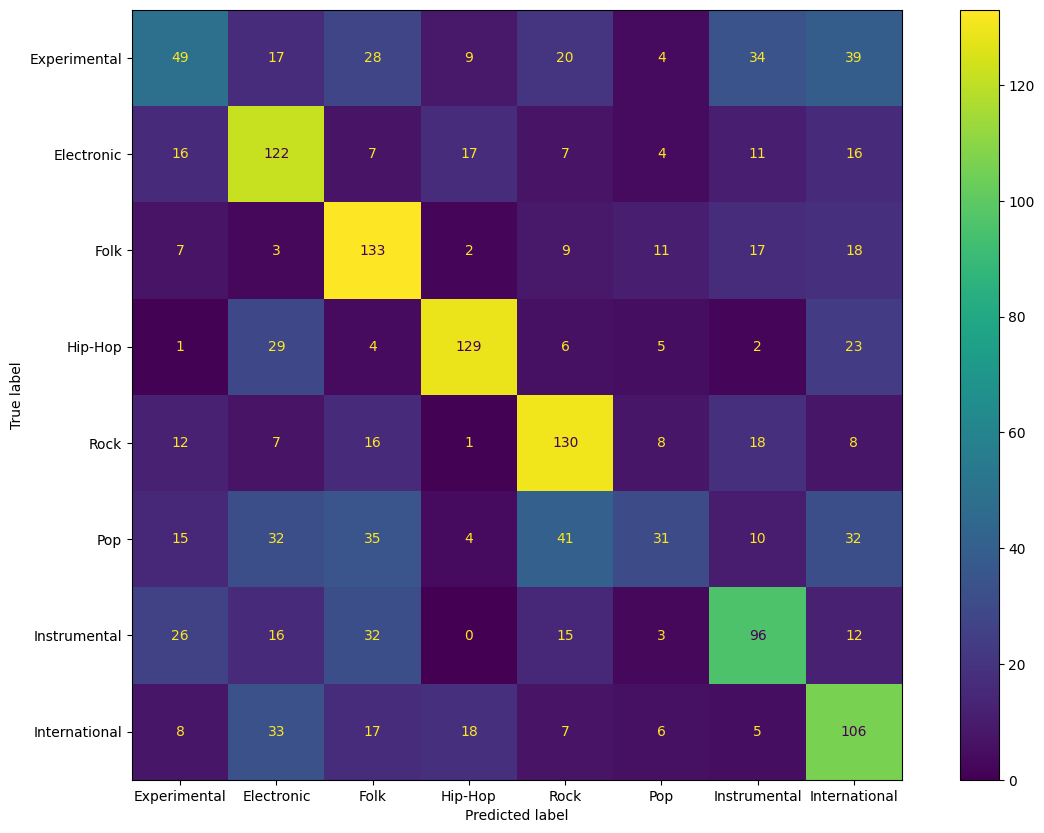

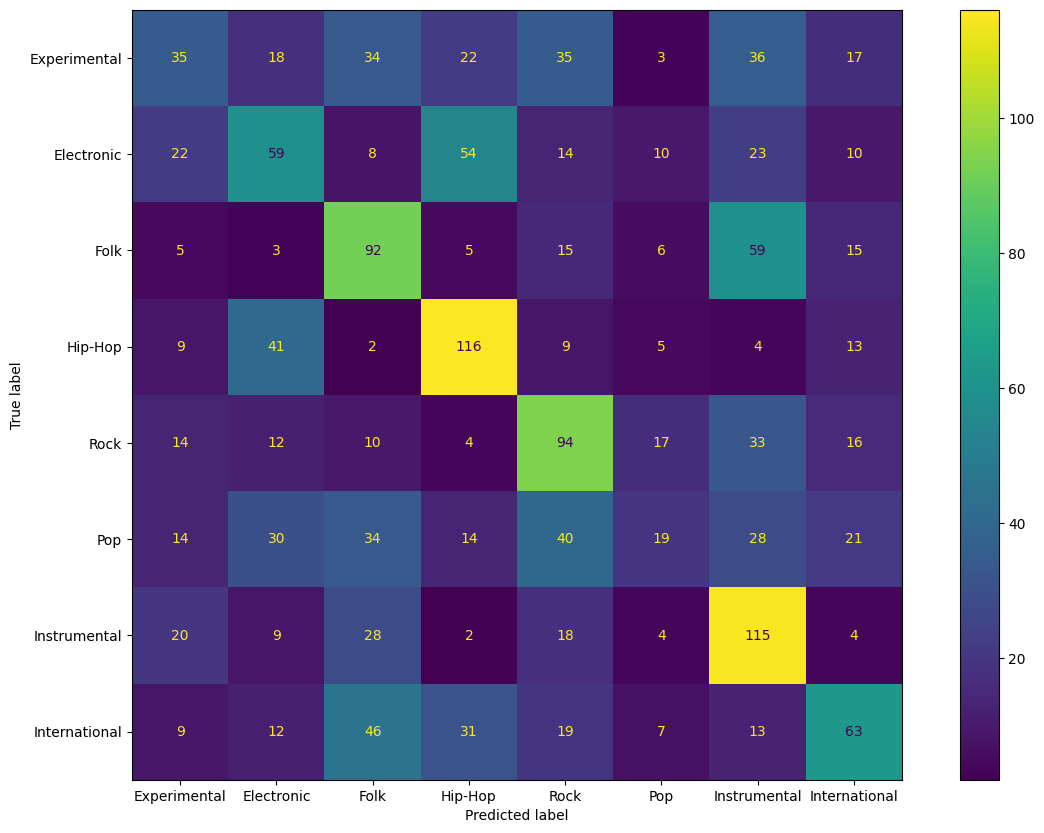

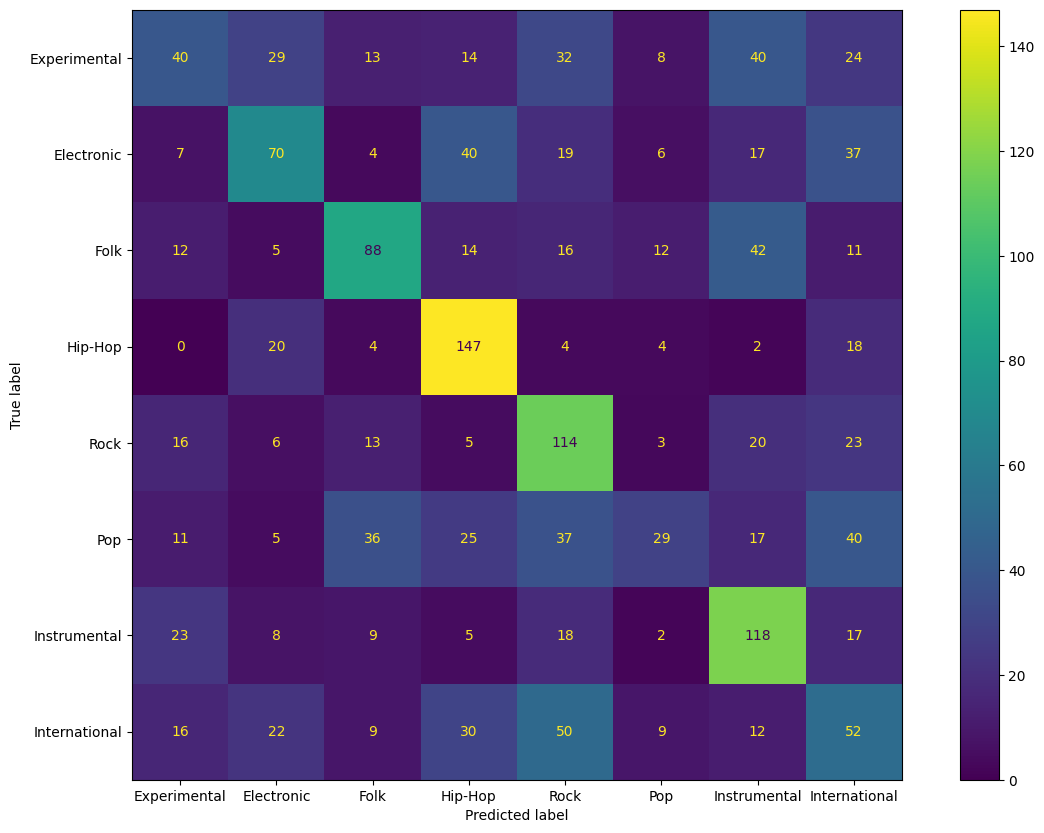

In [ ]:
num_classes = len(df['genre'].unique())
criterion = nn.CrossEntropyLoss()

# for each feature, train a model and evaluate it
for feature in ['mfcc', 'chroma', 'spectral']:
    log(f"-"*50)
    log(f"Training model for feature: {feature}")
    model = CNN_GRU_Classifier(n_dim=features_dim[feature], num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train_loader, val_loader, test_loader = get_data_loader(train_df, val_df, test_df, feature)

    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50)
    model.load_state_dict(torch.load('best_model.pth'))

    # Avaliar o modelo
    crnn_report[feature] = evaluate_model(model, test_loader, device)

### For raw data

In [ ]:
# CNN de Classificação
class CNN_GRU_Raw_Classifier(nn.Module):
    def __init__(self, n_dim=1, input_length=1291, num_classes=8):
        super(CNN_GRU_Raw_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv1d(n_dim, 64, kernel_size=3, stride=1, padding=1),  # (batch, 64, 1291)
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4),  # (batch, 64, 322)

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 322)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4),  # (batch, 128, 80)

            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 80)
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4, stride=4)  # (batch, 128, 20)
        )

        encoder_output_size = input_length // (4 * 4 * 4)  # Divisão pelas camadas MaxPool
        flattened_size = 128 * encoder_output_size

        self.gru = nn.GRU(input_size=128, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Linear(32 * 2, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Adiciona a dimensão de canal: (batch_size, 1, input_length)
        x = self.encoder(x)  # Saída: (batch_size, 128, seq_length)

        # Rearranjar para entrada na RNN: (batch_size, seq_length, features)
        x = x.permute(0, 2, 1)  # Saída: (batch_size, seq_length, 128)

        # Passar pela GRU
        gru_out, _ = self.gru(x)  # Saída: (batch_size, seq_length, hidden_size*2)
        gru_out = gru_out[:, -1, :]  # Pega a última saída da GRU: (batch_size, hidden_size*2)

        # Classificação
        out = self.fc(gru_out)  # Saída final (batch_size, num_classes)
        return out

--------------------------------------------------
Training model for feature: raw


Epoch 1/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.47it/s]


Validation Loss: 1.9890
Model saved with validation loss: 1.9890


Epoch 2/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.61it/s]


Validation Loss: 1.9565
Model saved with validation loss: 1.9565


Epoch 3/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:01<00:00, 81.13it/s]


Validation Loss: 1.9391
Model saved with validation loss: 1.9391


Epoch 4/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.78it/s]


Validation Loss: 1.9269
Model saved with validation loss: 1.9269


Epoch 5/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.62it/s]


Validation Loss: 1.9228
Model saved with validation loss: 1.9228


Epoch 6/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.40it/s]


Validation Loss: 1.9104
Model saved with validation loss: 1.9104


Epoch 7/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 72.80it/s]


Validation Loss: 1.9209


Epoch 8/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.05it/s]


Validation Loss: 1.9004
Model saved with validation loss: 1.9004


Epoch 9/50: 100%|███████████████████████████████████████████████████████| 160/160 [00:01<00:00, 80.50it/s]


Validation Loss: 1.8853
Model saved with validation loss: 1.8853


Epoch 10/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:01<00:00, 81.69it/s]


Validation Loss: 1.8928


Epoch 11/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 76.29it/s]


Validation Loss: 1.8951


Epoch 12/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.92it/s]


Validation Loss: 1.8857


Epoch 13/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.90it/s]


Validation Loss: 1.8819
Model saved with validation loss: 1.8819


Epoch 14/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.07it/s]


Validation Loss: 1.9090


Epoch 15/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.40it/s]


Validation Loss: 1.8929


Epoch 16/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.28it/s]


Validation Loss: 1.8951


Epoch 17/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.42it/s]


Validation Loss: 1.9039


Epoch 18/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.54it/s]


Validation Loss: 1.8948


Epoch 19/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.20it/s]


Validation Loss: 1.9144


Epoch 20/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.74it/s]


Validation Loss: 1.9041


Epoch 21/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.81it/s]


Validation Loss: 1.9178


Epoch 22/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.44it/s]


Validation Loss: 1.9274


Epoch 23/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.00it/s]


Validation Loss: 1.9341


Epoch 24/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.79it/s]


Validation Loss: 1.9451


Epoch 25/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.78it/s]


Validation Loss: 1.9661


Epoch 26/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.70it/s]


Validation Loss: 2.0027


Epoch 27/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.82it/s]


Validation Loss: 1.9958


Epoch 28/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.89it/s]


Validation Loss: 2.0146


Epoch 29/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.62it/s]


Validation Loss: 2.0369


Epoch 30/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.35it/s]


Validation Loss: 2.0552


Epoch 31/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.99it/s]


Validation Loss: 2.0756


Epoch 32/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.25it/s]


Validation Loss: 2.0876


Epoch 33/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.39it/s]


Validation Loss: 2.0990


Epoch 34/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.14it/s]


Validation Loss: 2.1714


Epoch 35/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.69it/s]


Validation Loss: 2.1603


Epoch 36/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.91it/s]


Validation Loss: 2.1870


Epoch 37/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.33it/s]


Validation Loss: 2.1954


Epoch 38/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.23it/s]


Validation Loss: 2.2626


Epoch 39/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.86it/s]


Validation Loss: 2.2661


Epoch 40/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.34it/s]


Validation Loss: 2.2785


Epoch 41/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.62it/s]


Validation Loss: 2.3276


Epoch 42/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.26it/s]


Validation Loss: 2.3142


Epoch 43/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.44it/s]


Validation Loss: 2.3897


Epoch 44/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.11it/s]


Validation Loss: 2.3693


Epoch 45/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.43it/s]


Validation Loss: 2.4312


Epoch 46/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.22it/s]


Validation Loss: 2.4049


Epoch 47/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.25it/s]


Validation Loss: 2.4237


Epoch 48/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 73.53it/s]


Validation Loss: 2.4911


Epoch 49/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 74.35it/s]


Validation Loss: 2.5226


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 160/160 [00:02<00:00, 75.39it/s]


Validation Loss: 2.5037


/tmp/ipykernel_3775670/1947083509.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


               precision    recall  f1-score   support

 Experimental       0.28      0.14      0.19       200
   Electronic       0.21      0.21      0.21       200
         Folk       0.31      0.05      0.09       200
      Hip-Hop       0.28      0.39      0.33       200
         Rock       0.19      0.20      0.19       199
          Pop       0.28      0.34      0.30       200
 Instrumental       0.31      0.41      0.35       200
International       0.30      0.41      0.35       200

     accuracy                           0.27      1599
    macro avg       0.27      0.27      0.25      1599
 weighted avg       0.27      0.27      0.25      1599



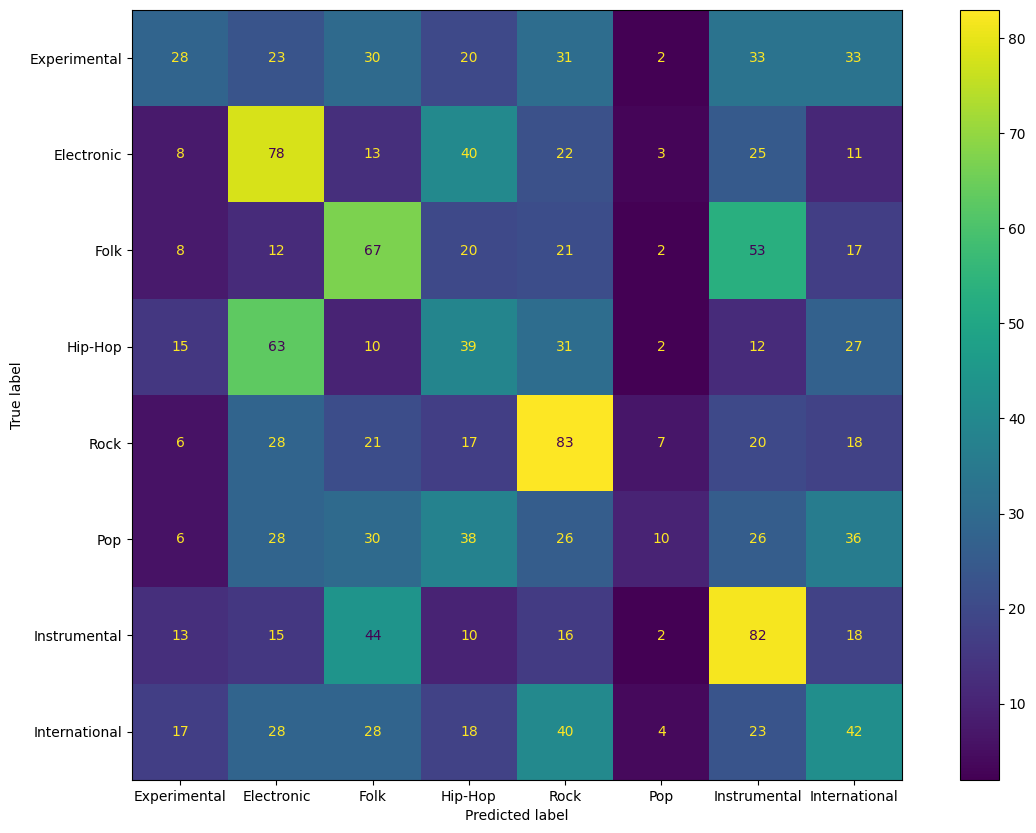

In [ ]:
num_classes = len(df['genre'].unique())
criterion = nn.CrossEntropyLoss()

# for raw feature, train a model and evaluate it
feature = 'raw'

log(f"-"*50)
log(f"Training model for feature: {feature}")
model = CNN_GRU_Raw_Classifier(n_dim=1, input_length=1291, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader, val_loader, test_loader = get_data_loader(train_df, val_df, test_df, feature)

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50)
model.load_state_dict(torch.load('best_model.pth'))

# Avaliar o modelo
crnn_report['raw'] = evaluate_model(model, test_loader, device)

In [ ]:
# save crnn_report
crnn_report_df = pd.DataFrame(crnn_report)
crnn_report_df.to_pickle('crnn_report.pkl')

## InceptionTime


In [ ]:
log('Experiment: InceptionTime')

In [ ]:
time_inception_report = {}

In [ ]:
def fit_and_evaluate(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    log('Train Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_train_pred)))

    y_test_pred = model.predict(X_test)
    log('Test Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_test_pred)))

    log(f"Classification report for feature {feature}")
    log(classification_report(y_test, y_test_pred, target_names=test_df['genre'].unique()))

    cm = confusion_matrix(y_test, y_test_pred, labels=test_df['label'].unique())
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_df['genre'].unique())
    fig, ax = plt.subplots(figsize=(15,10))
    cmd.plot(ax=ax)

    return classification_report(y_test, y_test_pred, target_names=test_df['genre'].unique(), output_dict=True)

--------------------------------------------------
Training model for feature: mfcc


2024-11-30 15:51:58.986885: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1291, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1291, 32)  │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1291, 13)  │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1291, 32)  │     40,960 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1291, 32)  │     20,480 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1291, 32)  │     10,240 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1291, 32)  │        416 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1291, 128) │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1291, 128) │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1291, 32)  │      4,096 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1291, 128) │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1291, 32)  │     40,960 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1291, 32)  │     20,480 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1291, 32)  │     10,240 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1291, 32)  │      4,096 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1291, 128) │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 495,048 (1.89 MB)

 Trainable params: 493,000 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 714ms/step - accuracy: 0.3492 - loss: 1.8422 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 739ms/step - accuracy: 0.4382 - loss: 1.5634 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 725ms/step - accuracy: 0.4690 - loss: 1.4839 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 733ms/step - accuracy: 0.4897 - loss: 1.4207 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 728ms/step - accuracy: 0.5117 - loss: 1.3689 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 731ms/step - accuracy: 0.5262 - loss: 1.3229 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 725ms/step - accuracy: 0.5419 - loss: 1.2800 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 732ms/step - accuracy: 0.5639 - loss: 1.2367 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 731ms/step - accuracy: 0.5770 - loss: 1.194

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1291, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 1291, 32)  │        416 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1291, 13)  │          0 │ input_layer_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 1291, 32)  │     40,960 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 1291, 32)  │     20,480 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 1291, 32)  │     10,240 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 1291, 32)  │        416 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1291, 128) │          0 │ conv1d_33[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 1291, 32)  │      4,096 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1291, 128) │          0 │ activation_8[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 1291, 32)  │     40,960 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 1291, 32)  │     20,480 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 1291, 32)  │     10,240 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 1291, 32)  │      4,096 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1291, 128) │          0 │ conv1d_38[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0],  │
│                     │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 495,048 (1.89 MB)

 Trainable params: 493,000 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 780ms/step - accuracy: 0.3393 - loss: 1.8295 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 760ms/step - accuracy: 0.4395 - loss: 1.5566 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.4664 - loss: 1.4787 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 766ms/step - accuracy: 0.4925 - loss: 1.4180 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.5104 - loss: 1.3642 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.5245 - loss: 1.3236 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 770ms/step - accuracy: 0.5390 - loss: 1.2812 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.5629 - loss: 1.2432 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 775ms/step - accuracy: 0.5754 - loss: 1.212

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1291, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 1291, 32)  │        416 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 1291, 13)  │          0 │ input_layer_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 1291, 32)  │     40,960 │ conv1d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 1291, 32)  │     20,480 │ conv1d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 1291, 32)  │     10,240 │ conv1d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 1291, 32)  │        416 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 1291, 128) │          0 │ conv1d_65[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_66[0][0],  │
│                     │                   │            │ conv1d_67[0][0],  │
│                     │                   │            │ conv1d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_12[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 1291, 32)  │      4,096 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 1291, 128) │          0 │ activation_16[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 1291, 32)  │     40,960 │ conv1d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 1291, 32)  │     20,480 │ conv1d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 1291, 32)  │     10,240 │ conv1d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 1291, 32)  │      4,096 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 1291, 128) │          0 │ conv1d_70[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_71[0][0],  │
│                     │                   │            │ conv1d_72[0][0],  │
│                     │                   │            │ conv1d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_13[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 495,048 (1.89 MB)

 Trainable params: 493,000 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 771ms/step - accuracy: 0.3319 - loss: 1.8438 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 758ms/step - accuracy: 0.4309 - loss: 1.5719 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 758ms/step - accuracy: 0.4537 - loss: 1.4934 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.4803 - loss: 1.4252 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.5056 - loss: 1.3736 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.5169 - loss: 1.3259 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.5333 - loss: 1.2846 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.5465 - loss: 1.2449 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 761ms/step - accuracy: 0.5682 - loss: 1.202

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1291, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 1291, 32)  │        416 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 1291, 13)  │          0 │ input_layer_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 1291, 32)  │     40,960 │ conv1d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 1291, 32)  │     20,480 │ conv1d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 1291, 32)  │     10,240 │ conv1d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 1291, 32)  │        416 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 1291, 128) │          0 │ conv1d_97[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_98[0][0],  │
│                     │                   │            │ conv1d_99[0][0],  │
│                     │                   │            │ conv1d_100[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_18[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 1291, 128) │          0 │ activation_24[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_104 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_105 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 1291, 128) │          0 │ conv1d_102[0][0], │
│ (Concatenate)       │                   │            │ conv1d_103[0][0], │
│                     │                   │            │ conv1d_104[0][0], │
│                     │                   │            │ conv1d_105[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_19[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 495,048 (1.89 MB)

 Trainable params: 493,000 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 765ms/step - accuracy: 0.3378 - loss: 1.8387 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.4225 - loss: 1.5705 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 767ms/step - accuracy: 0.4736 - loss: 1.4867 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.4944 - loss: 1.4319 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.5118 - loss: 1.3746 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.5262 - loss: 1.3288 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.5443 - loss: 1.2833 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.5595 - loss: 1.2389 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - accuracy: 0.5785 - loss: 1.194

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1291, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_128 (Conv1D) │ (None, 1291, 32)  │        416 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 1291, 13)  │          0 │ input_layer_4[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_129 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_128[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_130 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_128[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_131 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_128[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 1291, 32)  │        416 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 1291, 128) │          0 │ conv1d_129[0][0], │
│ (Concatenate)       │                   │            │ conv1d_130[0][0], │
│                     │                   │            │ conv1d_131[0][0], │
│                     │                   │            │ conv1d_132[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_24[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 1291, 128) │          0 │ activation_32[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_133[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_135 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_133[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_133[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 1291, 128) │          0 │ conv1d_134[0][0], │
│ (Concatenate)       │                   │            │ conv1d_135[0][0], │
│                     │                   │            │ conv1d_136[0][0], │
│                     │                   │            │ conv1d_137[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_25[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 495,048 (1.89 MB)

 Trainable params: 493,000 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 772ms/step - accuracy: 0.3308 - loss: 1.8392 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 767ms/step - accuracy: 0.4263 - loss: 1.5675 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 758ms/step - accuracy: 0.4643 - loss: 1.4843 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.4811 - loss: 1.4243 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 758ms/step - accuracy: 0.5059 - loss: 1.3799 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.5208 - loss: 1.3388 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.5368 - loss: 1.3004 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 765ms/step - accuracy: 0.5481 - loss: 1.2640 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 761ms/step - accuracy: 0.5654 - loss: 1.229

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1291, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 1291, 32)  │        384 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 1291, 12)  │          0 │ input_layer_5[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_160[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 1291, 32)  │        384 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 1291, 128) │          0 │ conv1d_161[0][0], │
│ (Concatenate)       │                   │            │ conv1d_162[0][0], │
│                     │                   │            │ conv1d_163[0][0], │
│                     │                   │            │ conv1d_164[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_30[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_40[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 1291, 128) │          0 │ activation_40[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_166 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_165[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_167 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_165[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_168 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_165[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_169 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 1291, 128) │          0 │ conv1d_166[0][0], │
│ (Concatenate)       │                   │            │ conv1d_167[0][0], │
│                     │                   │            │ conv1d_168[0][0], │
│                     │                   │            │ conv1d_169[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_31[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 494,856 (1.89 MB)

 Trainable params: 492,808 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 762ms/step - accuracy: 0.2883 - loss: 1.9352 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 759ms/step - accuracy: 0.3770 - loss: 1.7055 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.4050 - loss: 1.6317 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 761ms/step - accuracy: 0.4232 - loss: 1.5763 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.4483 - loss: 1.5311 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 764ms/step - accuracy: 0.4654 - loss: 1.4892 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.4767 - loss: 1.4503 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 763ms/step - accuracy: 0.4964 - loss: 1.4087 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 766ms/step - accuracy: 0.5088 - loss: 1.367

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1291, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_192 (Conv1D) │ (None, 1291, 32)  │        384 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 1291, 12)  │          0 │ input_layer_6[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_193 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_192[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_194 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_192[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_195 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_192[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_196 (Conv1D) │ (None, 1291, 32)  │        384 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 1291, 128) │          0 │ conv1d_193[0][0], │
│ (Concatenate)       │                   │            │ conv1d_194[0][0], │
│                     │                   │            │ conv1d_195[0][0], │
│                     │                   │            │ conv1d_196[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_36[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_197 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_48[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 1291, 128) │          0 │ activation_48[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_198 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_197[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_199 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_197[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_200 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_197[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_201 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 1291, 128) │          0 │ conv1d_198[0][0], │
│ (Concatenate)       │                   │            │ conv1d_199[0][0], │
│                     │                   │            │ conv1d_200[0][0], │
│                     │                   │            │ conv1d_201[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_37[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 494,856 (1.89 MB)

 Trainable params: 492,808 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 788ms/step - accuracy: 0.2813 - loss: 1.9317 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.3783 - loss: 1.7014 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 770ms/step - accuracy: 0.4180 - loss: 1.6261 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.4316 - loss: 1.5722 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 770ms/step - accuracy: 0.4521 - loss: 1.5275 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 768ms/step - accuracy: 0.4734 - loss: 1.4866 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - accuracy: 0.4917 - loss: 1.4472 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 767ms/step - accuracy: 0.5010 - loss: 1.4085 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 778ms/step - accuracy: 0.5195 - loss: 1.372

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1291, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_224 (Conv1D) │ (None, 1291, 32)  │        384 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_42    │ (None, 1291, 12)  │          0 │ input_layer_7[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_225 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_224[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_226 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_224[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_227 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_224[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_228 (Conv1D) │ (None, 1291, 32)  │        384 │ max_pooling1d_42… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 1291, 128) │          0 │ conv1d_225[0][0], │
│ (Concatenate)       │                   │            │ conv1d_226[0][0], │
│                     │                   │            │ conv1d_227[0][0], │
│                     │                   │            │ conv1d_228[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_42[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_229 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_56[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 1291, 128) │          0 │ activation_56[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_230 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_229[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_231 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_229[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_232 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_229[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_233 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_43… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_43      │ (None, 1291, 128) │          0 │ conv1d_230[0][0], │
│ (Concatenate)       │                   │            │ conv1d_231[0][0], │
│                     │                   │            │ conv1d_232[0][0], │
│                     │                   │            │ conv1d_233[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_43[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 494,856 (1.89 MB)

 Trainable params: 492,808 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 781ms/step - accuracy: 0.2895 - loss: 1.9288 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - accuracy: 0.3820 - loss: 1.6921 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.4050 - loss: 1.6260 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 777ms/step - accuracy: 0.4363 - loss: 1.5721 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.4512 - loss: 1.5278 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 775ms/step - accuracy: 0.4670 - loss: 1.4857 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.4781 - loss: 1.4461 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.4948 - loss: 1.4116 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.5084 - loss: 1.377

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1291, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_256 (Conv1D) │ (None, 1291, 32)  │        384 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_48    │ (None, 1291, 12)  │          0 │ input_layer_8[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_257 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_256[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_258 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_256[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_259 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_256[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_260 (Conv1D) │ (None, 1291, 32)  │        384 │ max_pooling1d_48… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 1291, 128) │          0 │ conv1d_257[0][0], │
│ (Concatenate)       │                   │            │ conv1d_258[0][0], │
│                     │                   │            │ conv1d_259[0][0], │
│                     │                   │            │ conv1d_260[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_48[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_261 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_64[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_49    │ (None, 1291, 128) │          0 │ activation_64[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_262 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_261[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_263 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_261[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_264 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_261[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_265 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_49… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 1291, 128) │          0 │ conv1d_262[0][0], │
│ (Concatenate)       │                   │            │ conv1d_263[0][0], │
│                     │                   │            │ conv1d_264[0][0], │
│                     │                   │            │ conv1d_265[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_49[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 494,856 (1.89 MB)

 Trainable params: 492,808 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 774ms/step - accuracy: 0.2862 - loss: 1.9024 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - accuracy: 0.3825 - loss: 1.6784 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.4064 - loss: 1.6108 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 770ms/step - accuracy: 0.4294 - loss: 1.5602 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.4537 - loss: 1.5156 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 778ms/step - accuracy: 0.4677 - loss: 1.4768 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 774ms/step - accuracy: 0.4856 - loss: 1.4388 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 779ms/step - accuracy: 0.5057 - loss: 1.3992 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 772ms/step - accuracy: 0.5170 - loss: 1.361

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1291, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_288 (Conv1D) │ (None, 1291, 32)  │        384 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_54    │ (None, 1291, 12)  │          0 │ input_layer_9[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_289 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_288[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_290 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_288[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_291 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_288[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_292 (Conv1D) │ (None, 1291, 32)  │        384 │ max_pooling1d_54… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 1291, 128) │          0 │ conv1d_289[0][0], │
│ (Concatenate)       │                   │            │ conv1d_290[0][0], │
│                     │                   │            │ conv1d_291[0][0], │
│                     │                   │            │ conv1d_292[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_54[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_293 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_72[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_55    │ (None, 1291, 128) │          0 │ activation_72[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_294 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_293[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_295 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_293[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_296 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_293[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_297 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 1291, 128) │          0 │ conv1d_294[0][0], │
│ (Concatenate)       │                   │            │ conv1d_295[0][0], │
│                     │                   │            │ conv1d_296[0][0], │
│                     │                   │            │ conv1d_297[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_55[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 1291, 128) │          0 │ batch_normalizat

 Total params: 494,856 (1.89 MB)

 Trainable params: 492,808 (1.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 162s 778ms/step - accuracy: 0.2659 - loss: 1.9332 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.3458 - loss: 1.7347 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 775ms/step - accuracy: 0.3857 - loss: 1.6576 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 768ms/step - accuracy: 0.4097 - loss: 1.6061 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 769ms/step - accuracy: 0.4316 - loss: 1.5627 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 770ms/step - accuracy: 0.4499 - loss: 1.5242 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 771ms/step - accuracy: 0.4596 - loss: 1.4898 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 780ms/step - accuracy: 0.4765 - loss: 1.4560 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 773ms/step - accuracy: 0.4927 - loss: 1.422

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 1291, 1)   │          0 │ input_layer_10[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_320 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_321 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_322 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_323 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_60… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_60      │ (None, 1291, 128) │          0 │ conv1d_320[0][0], │
│ (Concatenate)       │                   │            │ conv1d_321[0][0], │
│                     │                   │            │ conv1d_322[0][0], │
│                     │                   │            │ conv1d_323[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_60[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_324 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_80[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 1291, 128) │          0 │ activation_80[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_325 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_324[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_326 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_324[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_327 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_324[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_328 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_61      │ (None, 1291, 128) │          0 │ conv1d_325[0][0], │
│ (Concatenate)       │                   │            │ conv1d_326[0][0], │
│                     │                   │            │ conv1d_327[0][0], │
│                     │                   │            │ conv1d_328[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_61[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 666ms/step - accuracy: 0.3017 - loss: 1.9060 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.3737 - loss: 1.7134 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 662ms/step - accuracy: 0.3904 - loss: 1.6778 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 667ms/step - accuracy: 0.4027 - loss: 1.6450 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.4156 - loss: 1.6204 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 665ms/step - accuracy: 0.4186 - loss: 1.5996 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 662ms/step - accuracy: 0.4294 - loss: 1.5824 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 667ms/step - accuracy: 0.4358 - loss: 1.5618 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 666ms/step - accuracy: 0.4479 - loss: 1.540

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_66    │ (None, 1291, 1)   │          0 │ input_layer_11[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_351 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_352 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_353 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_354 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_66… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_66      │ (None, 1291, 128) │          0 │ conv1d_351[0][0], │
│ (Concatenate)       │                   │            │ conv1d_352[0][0], │
│                     │                   │            │ conv1d_353[0][0], │
│                     │                   │            │ conv1d_354[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_66[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_355 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_88[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_67    │ (None, 1291, 128) │          0 │ activation_88[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_356 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_355[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_357 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_355[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_358 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_355[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_359 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_67… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_67      │ (None, 1291, 128) │          0 │ conv1d_356[0][0], │
│ (Concatenate)       │                   │            │ conv1d_357[0][0], │
│                     │                   │            │ conv1d_358[0][0], │
│                     │                   │            │ conv1d_359[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_67[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_89       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 661ms/step - accuracy: 0.2914 - loss: 1.9070 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 662ms/step - accuracy: 0.3707 - loss: 1.7227 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.3845 - loss: 1.6797 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.3876 - loss: 1.6524 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.4097 - loss: 1.6235 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 663ms/step - accuracy: 0.4156 - loss: 1.6011 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.4187 - loss: 1.5787 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 659ms/step - accuracy: 0.4292 - loss: 1.5574 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.4407 - loss: 1.534

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_72    │ (None, 1291, 1)   │          0 │ input_layer_12[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_382 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_383 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_384 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_385 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_72… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_72      │ (None, 1291, 128) │          0 │ conv1d_382[0][0], │
│ (Concatenate)       │                   │            │ conv1d_383[0][0], │
│                     │                   │            │ conv1d_384[0][0], │
│                     │                   │            │ conv1d_385[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_72[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_386 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_96[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_73    │ (None, 1291, 128) │          0 │ activation_96[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_387 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_386[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_388 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_386[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_389 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_386[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_390 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_73… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_73      │ (None, 1291, 128) │          0 │ conv1d_387[0][0], │
│ (Concatenate)       │                   │            │ conv1d_388[0][0], │
│                     │                   │            │ conv1d_389[0][0], │
│                     │                   │            │ conv1d_390[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_73[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 660ms/step - accuracy: 0.2906 - loss: 1.8989 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.3538 - loss: 1.7474 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 134s 668ms/step - accuracy: 0.3713 - loss: 1.7055 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 657ms/step - accuracy: 0.3865 - loss: 1.6768 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 654ms/step - accuracy: 0.4036 - loss: 1.6511 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 655ms/step - accuracy: 0.4149 - loss: 1.6317 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 655ms/step - accuracy: 0.4214 - loss: 1.6101 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 130s 651ms/step - accuracy: 0.4313 - loss: 1.5914 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 130s 652ms/step - accuracy: 0.4350 - loss: 1.573

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_78    │ (None, 1291, 1)   │          0 │ input_layer_13[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_413 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_414 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_415 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_416 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_78… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_78      │ (None, 1291, 128) │          0 │ conv1d_413[0][0], │
│ (Concatenate)       │                   │            │ conv1d_414[0][0], │
│                     │                   │            │ conv1d_415[0][0], │
│                     │                   │            │ conv1d_416[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_78[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_417 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_104[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_79    │ (None, 1291, 128) │          0 │ activation_104[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_418 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_417[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_419 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_417[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_420 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_417[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_421 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_79… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_79      │ (None, 1291, 128) │          0 │ conv1d_418[0][0], │
│ (Concatenate)       │                   │            │ conv1d_419[0][0], │
│                     │                   │            │ conv1d_420[0][0], │
│                     │                   │            │ conv1d_421[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_79[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_105      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 670ms/step - accuracy: 0.2985 - loss: 1.8878 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.3727 - loss: 1.7158 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 664ms/step - accuracy: 0.3856 - loss: 1.6750 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.3997 - loss: 1.6423 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 657ms/step - accuracy: 0.4144 - loss: 1.6170 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 655ms/step - accuracy: 0.4152 - loss: 1.5959 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 663ms/step - accuracy: 0.4289 - loss: 1.5758 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 657ms/step - accuracy: 0.4339 - loss: 1.5530 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 656ms/step - accuracy: 0.4447 - loss: 1.532

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_84    │ (None, 1291, 1)   │          0 │ input_layer_14[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_444 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_445 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_446 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_447 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_84… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_84      │ (None, 1291, 128) │          0 │ conv1d_444[0][0], │
│ (Concatenate)       │                   │            │ conv1d_445[0][0], │
│                     │                   │            │ conv1d_446[0][0], │
│                     │                   │            │ conv1d_447[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_84[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_112      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_448 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_112[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_85    │ (None, 1291, 128) │          0 │ activation_112[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_449 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_448[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_450 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_448[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_451 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_448[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_452 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_85… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_85      │ (None, 1291, 128) │          0 │ conv1d_449[0][0], │
│ (Concatenate)       │                   │            │ conv1d_450[0][0], │
│                     │                   │            │ conv1d_451[0][0], │
│                     │                   │            │ conv1d_452[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_85[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_113      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 667ms/step - accuracy: 0.2908 - loss: 1.8938 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 667ms/step - accuracy: 0.3659 - loss: 1.7255 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.3853 - loss: 1.6791 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.3907 - loss: 1.6466 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 656ms/step - accuracy: 0.4089 - loss: 1.6178 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 661ms/step - accuracy: 0.4206 - loss: 1.5944 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 658ms/step - accuracy: 0.4259 - loss: 1.5716 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 660ms/step - accuracy: 0.4333 - loss: 1.5511 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 666ms/step - accuracy: 0.4406 - loss: 1.532

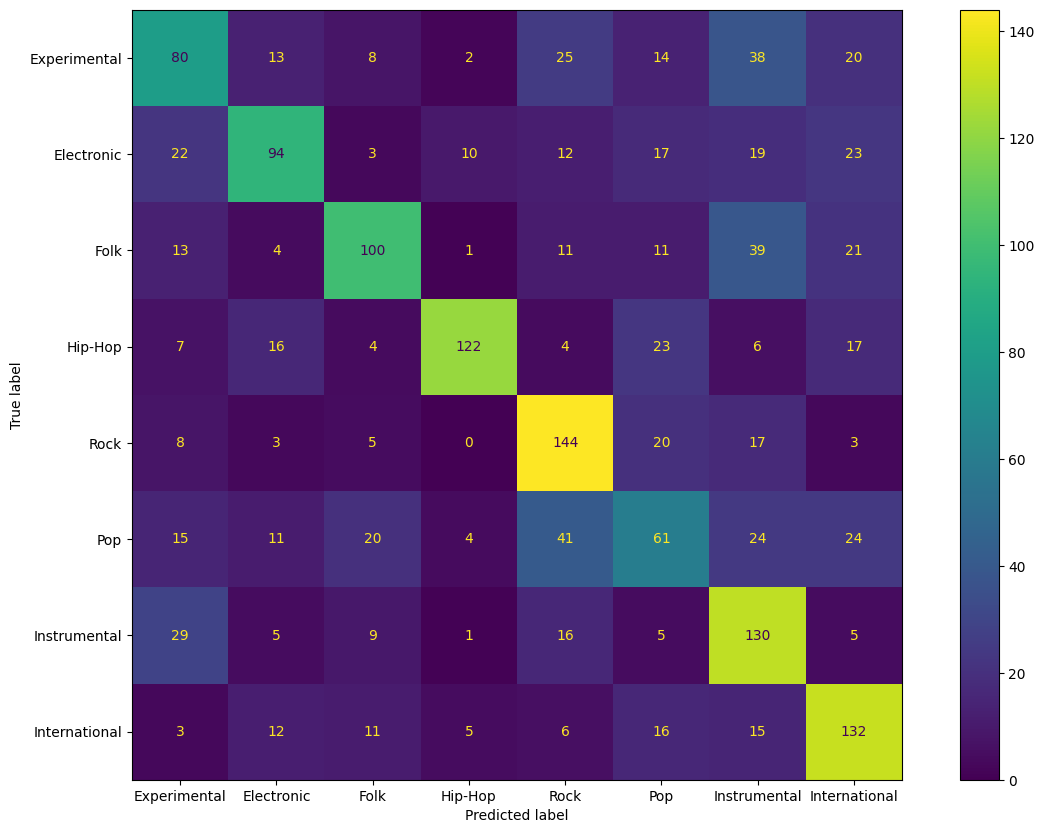

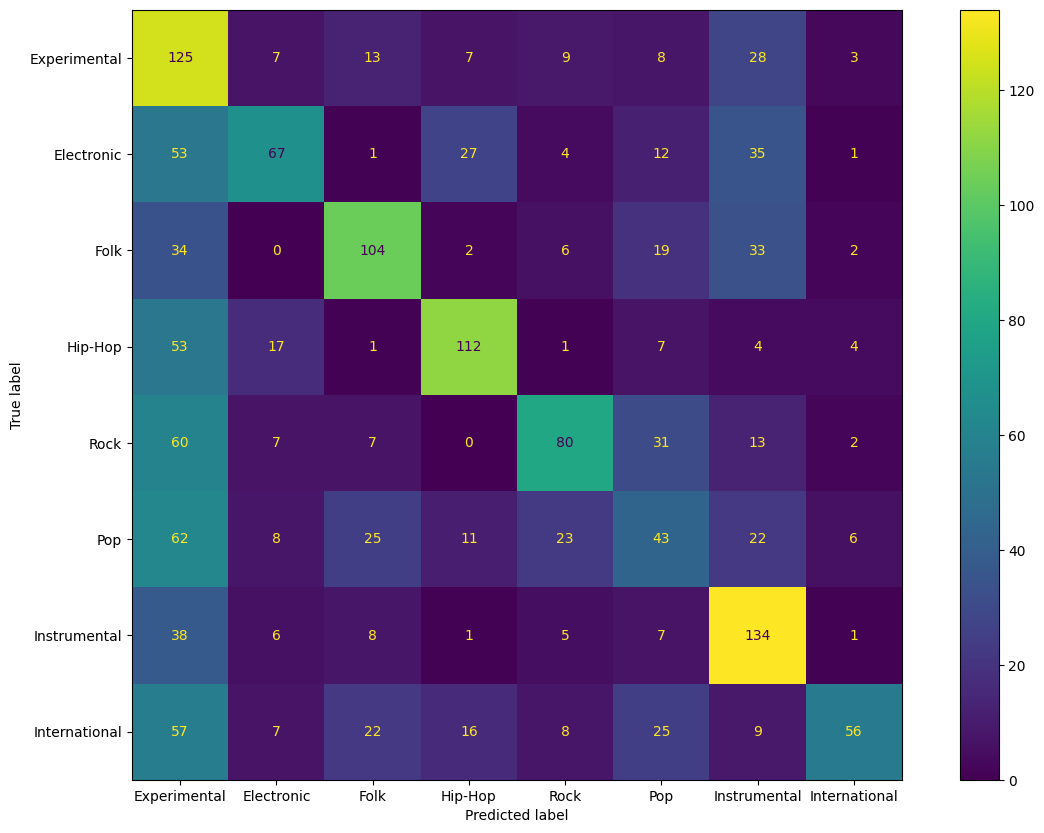

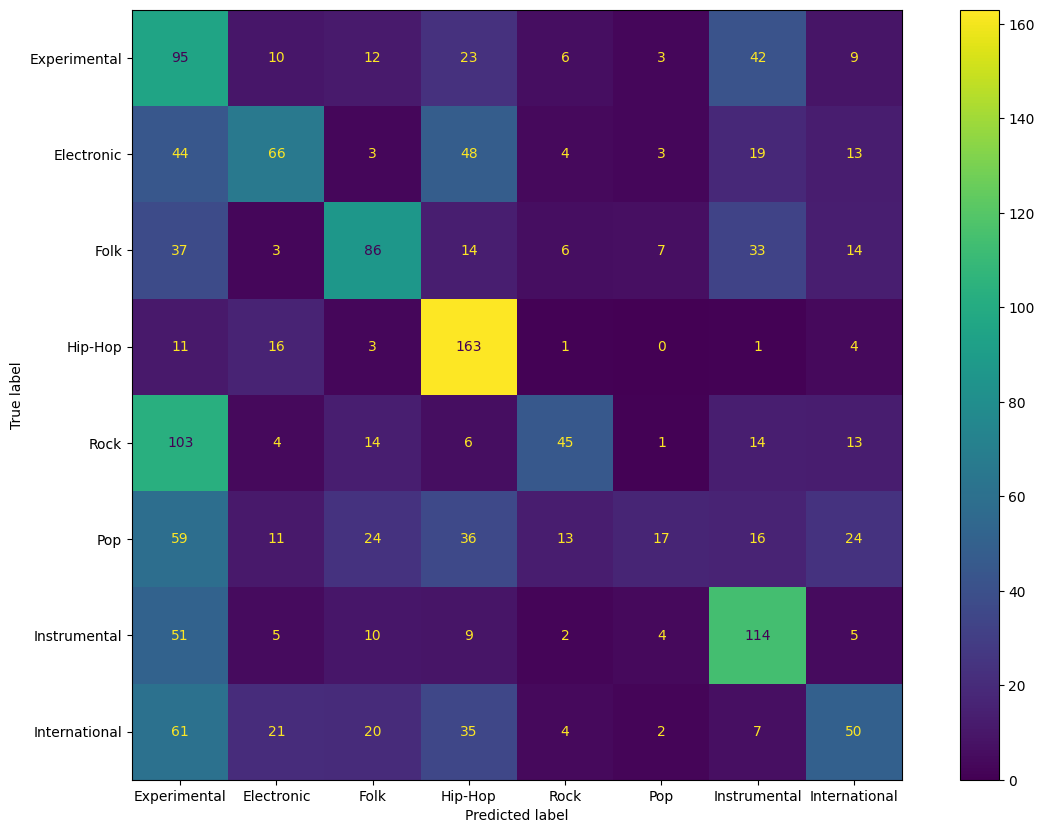

In [ ]:
# for each feature, train a model and evaluate it
for feature in ['mfcc', 'chroma', 'spectral']:
    log(f"-"*50)
    log(f"Training model for feature: {feature}")

    X_train = np.concatenate((np.stack(train_df[feature].values), np.stack(val_df[feature].values)), axis=0)
    y_train = np.concatenate((train_df['label'].values, val_df['label'].values))

    X_test = np.stack(test_df[feature].values)
    y_test = test_df['label'].values

    model = InceptionTimeClassifier(n_epochs=20,batch_size=32, verbose=True)
    time_inception_report[feature] = fit_and_evaluate(X_train, y_train, X_test, y_test, model)


### Raw

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_90    │ (None, 1291, 1)   │          0 │ input_layer_15[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_475 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_476 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_477 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_478 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_90… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_90      │ (None, 1291, 128) │          0 │ conv1d_475[0][0], │
│ (Concatenate)       │                   │            │ conv1d_476[0][0], │
│                     │                   │            │ conv1d_477[0][0], │
│                     │                   │            │ conv1d_478[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_90[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_479 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_120[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_91    │ (None, 1291, 128) │          0 │ activation_120[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_480 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_479[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_481 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_479[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_482 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_479[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_483 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_91… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_91      │ (None, 1291, 128) │          0 │ conv1d_480[0][0], │
│ (Concatenate)       │                   │            │ conv1d_481[0][0], │
│                     │                   │            │ conv1d_482[0][0], │
│                     │                   │            │ conv1d_483[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_91[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 129s 619ms/step - accuracy: 0.2080 - loss: 2.0491 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 618ms/step - accuracy: 0.2416 - loss: 1.9527 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.2501 - loss: 1.9296 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 617ms/step - accuracy: 0.2564 - loss: 1.9192 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 618ms/step - accuracy: 0.2654 - loss: 1.9079 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.2766 - loss: 1.8992 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.2816 - loss: 1.8902 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 619ms/step - accuracy: 0.2864 - loss: 1.8838 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 620ms/step - accuracy: 0.2828 - loss: 1.879

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_96    │ (None, 1291, 1)   │          0 │ input_layer_16[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_506 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_507 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_508 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_509 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_96… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_96      │ (None, 1291, 128) │          0 │ conv1d_506[0][0], │
│ (Concatenate)       │                   │            │ conv1d_507[0][0], │
│                     │                   │            │ conv1d_508[0][0], │
│                     │                   │            │ conv1d_509[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_96[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_128      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_510 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_128[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_97    │ (None, 1291, 128) │          0 │ activation_128[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_511 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_510[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_512 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_510[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_513 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_510[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_514 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_97… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_97      │ (None, 1291, 128) │          0 │ conv1d_511[0][0], │
│ (Concatenate)       │                   │            │ conv1d_512[0][0], │
│                     │                   │            │ conv1d_513[0][0], │
│                     │                   │            │ conv1d_514[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_97[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_129      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 634ms/step - accuracy: 0.1938 - loss: 2.0655 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 623ms/step - accuracy: 0.2511 - loss: 1.9595 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 626ms/step - accuracy: 0.2655 - loss: 1.9350 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 623ms/step - accuracy: 0.2656 - loss: 1.9198 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 623ms/step - accuracy: 0.2699 - loss: 1.9057 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 629ms/step - accuracy: 0.2706 - loss: 1.8941 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 634ms/step - accuracy: 0.2762 - loss: 1.8845 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 633ms/step - accuracy: 0.2774 - loss: 1.8751 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 626ms/step - accuracy: 0.2848 - loss: 1.867

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_102   │ (None, 1291, 1)   │          0 │ input_layer_17[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_537 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_538 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_539 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_540 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_102     │ (None, 1291, 128) │          0 │ conv1d_537[0][0], │
│ (Concatenate)       │                   │            │ conv1d_538[0][0], │
│                     │                   │            │ conv1d_539[0][0], │
│                     │                   │            │ conv1d_540[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_102[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_136      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_541 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_136[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_103   │ (None, 1291, 128) │          0 │ activation_136[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_542 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_541[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_543 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_541[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_544 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_541[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_545 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_103     │ (None, 1291, 128) │          0 │ conv1d_542[0][0], │
│ (Concatenate)       │                   │            │ conv1d_543[0][0], │
│                     │                   │            │ conv1d_544[0][0], │
│                     │                   │            │ conv1d_545[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_103[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 629ms/step - accuracy: 0.1961 - loss: 2.0528 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 626ms/step - accuracy: 0.2465 - loss: 1.9687 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 630ms/step - accuracy: 0.2611 - loss: 1.9439 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 626ms/step - accuracy: 0.2707 - loss: 1.9283 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 629ms/step - accuracy: 0.2789 - loss: 1.9163 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 629ms/step - accuracy: 0.2797 - loss: 1.9087 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 635ms/step - accuracy: 0.2816 - loss: 1.9023 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 627ms/step - accuracy: 0.2835 - loss: 1.8941 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 623ms/step - accuracy: 0.2877 - loss: 1.888

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_108   │ (None, 1291, 1)   │          0 │ input_layer_18[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_568 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_569 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_570 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_571 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_108     │ (None, 1291, 128) │          0 │ conv1d_568[0][0], │
│ (Concatenate)       │                   │            │ conv1d_569[0][0], │
│                     │                   │            │ conv1d_570[0][0], │
│                     │                   │            │ conv1d_571[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_108[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_144      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_572 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_144[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_109   │ (None, 1291, 128) │          0 │ activation_144[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_573 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_572[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_574 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_572[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_575 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_572[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_576 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_109     │ (None, 1291, 128) │          0 │ conv1d_573[0][0], │
│ (Concatenate)       │                   │            │ conv1d_574[0][0], │
│                     │                   │            │ conv1d_575[0][0], │
│                     │                   │            │ conv1d_576[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_109[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_145      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 635ms/step - accuracy: 0.2028 - loss: 2.0660 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.2464 - loss: 1.9641 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 627ms/step - accuracy: 0.2632 - loss: 1.9407 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 628ms/step - accuracy: 0.2773 - loss: 1.9251 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 627ms/step - accuracy: 0.2745 - loss: 1.9156 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 625ms/step - accuracy: 0.2749 - loss: 1.9060 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 624ms/step - accuracy: 0.2832 - loss: 1.8970 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 627ms/step - accuracy: 0.2864 - loss: 1.8900 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 625ms/step - accuracy: 0.2866 - loss: 1.881

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 1291, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_114   │ (None, 1291, 1)   │          0 │ input_layer_19[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_599 (Conv1D) │ (None, 1291, 32)  │      1,280 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_600 (Conv1D) │ (None, 1291, 32)  │        640 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_601 (Conv1D) │ (None, 1291, 32)  │        320 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_602 (Conv1D) │ (None, 1291, 32)  │         32 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_114     │ (None, 1291, 128) │          0 │ conv1d_599[0][0], │
│ (Concatenate)       │                   │            │ conv1d_600[0][0], │
│                     │                   │            │ conv1d_601[0][0], │
│                     │                   │            │ conv1d_602[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_114[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_152      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_603 (Conv1D) │ (None, 1291, 32)  │      4,096 │ activation_152[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_115   │ (None, 1291, 128) │          0 │ activation_152[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_604 (Conv1D) │ (None, 1291, 32)  │     40,960 │ conv1d_603[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_605 (Conv1D) │ (None, 1291, 32)  │     20,480 │ conv1d_603[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_606 (Conv1D) │ (None, 1291, 32)  │     10,240 │ conv1d_603[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_607 (Conv1D) │ (None, 1291, 32)  │      4,096 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_115     │ (None, 1291, 128) │          0 │ conv1d_604[0][0], │
│ (Concatenate)       │                   │            │ conv1d_605[0][0], │
│                     │                   │            │ conv1d_606[0][0], │
│                     │                   │            │ conv1d_607[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1291, 128) │        512 │ concatenate_115[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_153      │ (None, 1291, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 423,272 (1.61 MB)

 Trainable params: 421,224 (1.61 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 633ms/step - accuracy: 0.1938 - loss: 2.0575 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.2372 - loss: 1.9648 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 627ms/step - accuracy: 0.2500 - loss: 1.9379 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 624ms/step - accuracy: 0.2688 - loss: 1.9229 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.2738 - loss: 1.9101 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 622ms/step - accuracy: 0.2822 - loss: 1.8981 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 633ms/step - accuracy: 0.2856 - loss: 1.8870 - learning_rate: 0.0010
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 627ms/step - accuracy: 0.2888 - loss: 1.8771 - learning_rate: 0.0010
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 625ms/step - accuracy: 0.2925 - loss: 1.867

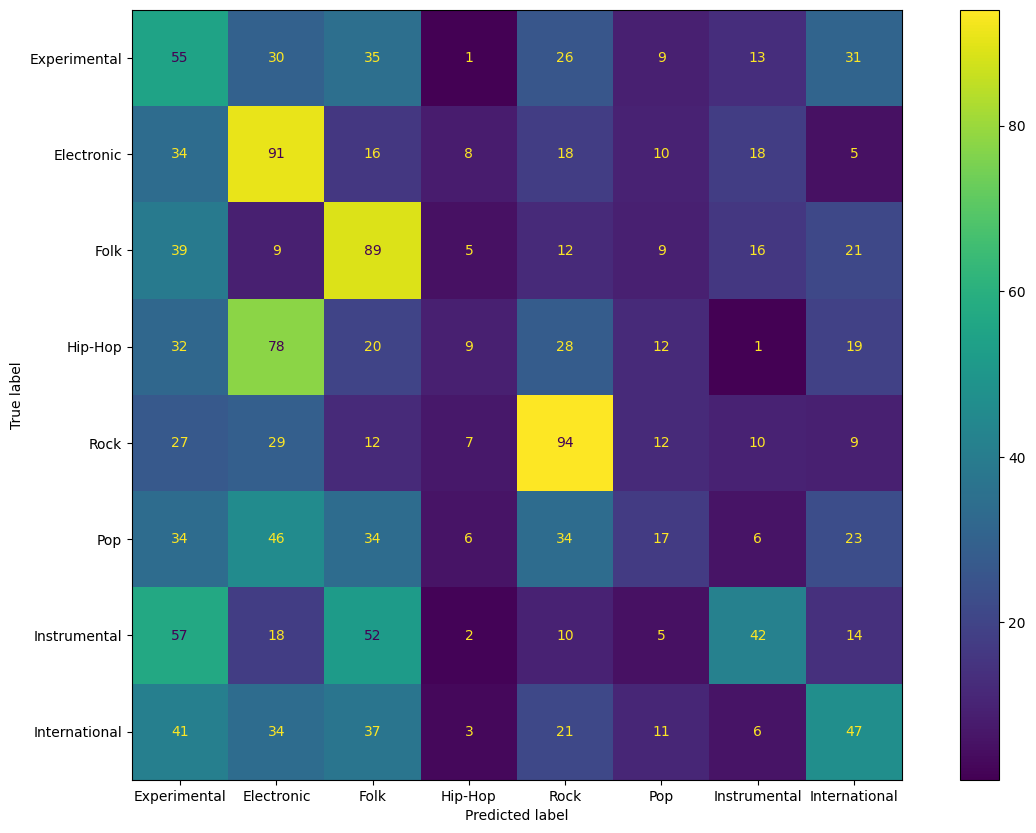

In [ ]:
X_train = np.concatenate((np.stack(train_df['raw'].values), np.stack(val_df['raw'].values)), axis=0)
y_train = np.concatenate((train_df['label'].values, val_df['label'].values))

# X_train = X_train[:, np.newaxis, :]

X_test = np.stack(test_df['raw'].values)
# X_test = X_test[:, np.newaxis, :]
y_test = test_df['label'].values

model = InceptionTimeClassifier(n_epochs=20,batch_size=32, verbose=True)
time_inception_report['raw'] = fit_and_evaluate(X_train, y_train, X_test, y_test, model)

In [ ]:
# save time_inception_report
time_inception_report_df = pd.DataFrame(time_inception_report)
time_inception_report_df.to_pickle('time_inception_report.pkl')

## Detach-ROCKET (ou POCKET)

---



---



Detach-Rocket: https://github.com/gon-uri/detach_rocket

In [ ]:
log('Experiment: Detach-ROCKET')

Experiment: Detach-ROCKET


In [ ]:
detach_report = {}

### Using MFCC, Chroma and Spectral

In [ ]:
def plot_channel_relevance(model):
  x = range(1, model.num_channels + 1)
  channel_relevance = model.estimate_channel_relevance()

  plt.figure(figsize=(8,3.5))
  plt.bar(x, channel_relevance, color='C7', zorder=2)

  plt.title('Channel relevance estimation')
  plt.grid(True, linestyle='-', alpha=0.5, zorder=1)
  plt.xlabel('Channels')
  plt.ylabel('Relevance Estimation (arb. unit)')
  plt.show()

--------------------------------------------------
Training model for feature: mfcc
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 428.13
Train Accuraccy Full ROCKET: 68.30%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 428.13
Train Accuraccy Detach Model: 61.97%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 428.13
Train Accuraccy Full ROCKET: 68.02%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 37.93
Train Accuraccy Detach Model: 59.59%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 428.13
Train Accuraccy Full ROCKET: 68.33%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 37.93
Train Accuraccy Detach Model: 57.47%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 428.13
Train Accuraccy Full ROCKET: 68.27%
-------------------------
TRAINING RESULTS Detach Mod

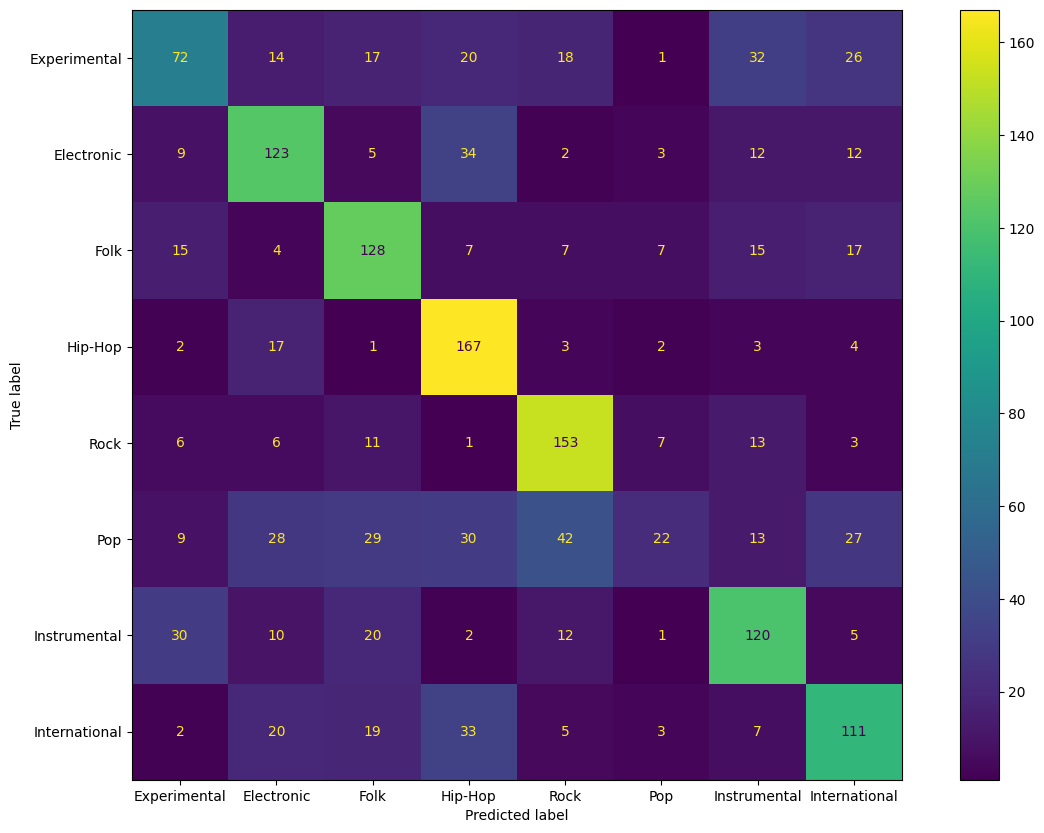

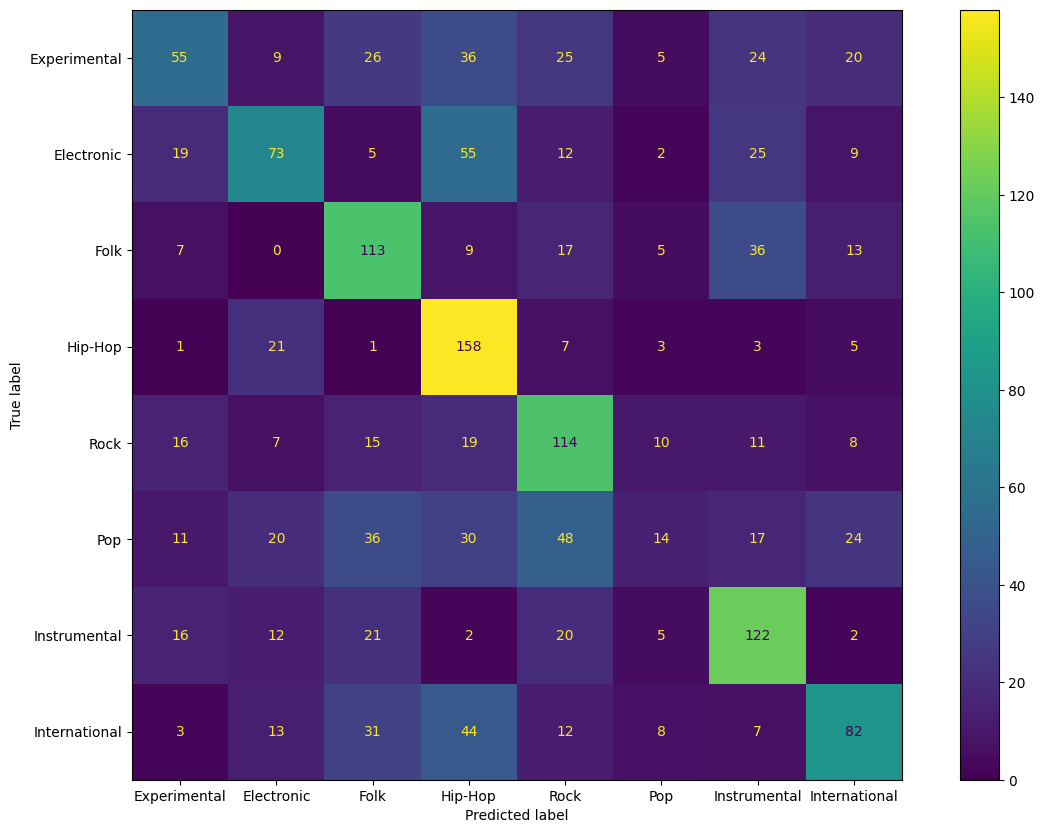

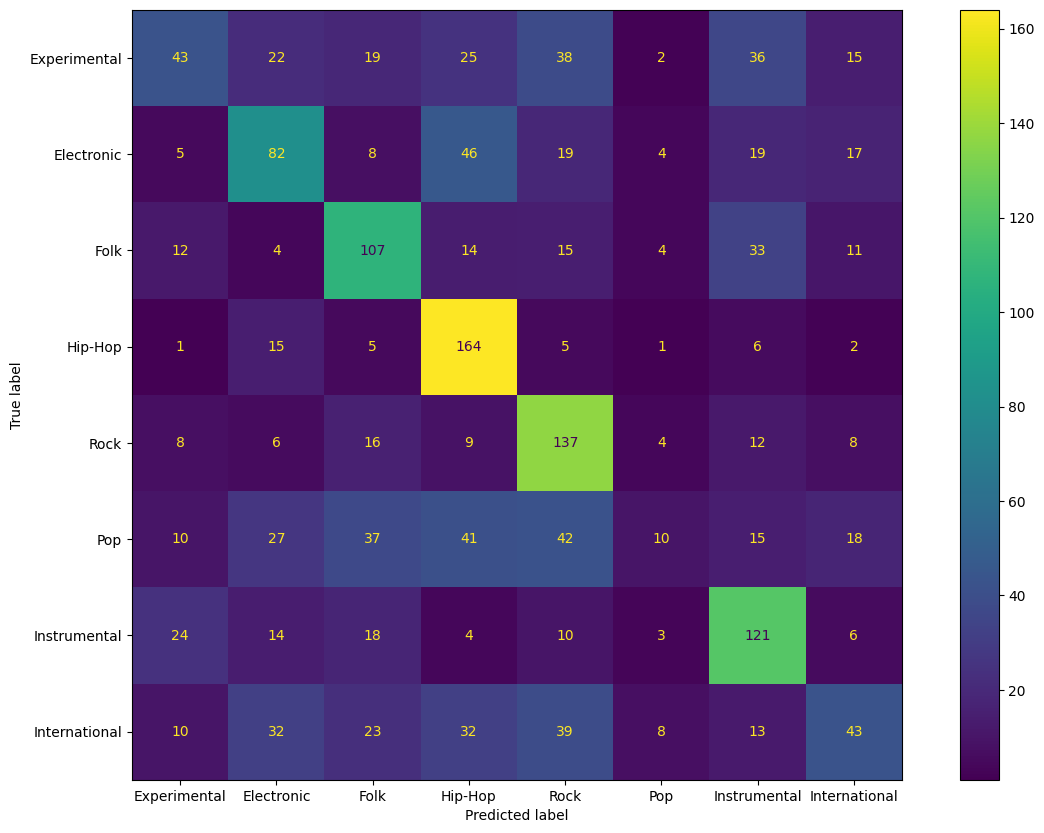

In [ ]:
# for each feature, train a model and evaluate it
for feature in ['mfcc', 'chroma', 'spectral']:
    log(f"-"*50)
    log(f"Training model for feature: {feature}")

    X_train = np.concatenate((np.stack(train_df[feature].values), np.stack(val_df[feature].values)), axis=0)
    y_train = np.concatenate((train_df['label'].values, val_df['label'].values))

    X_test = np.stack(test_df[feature].values)
    y_test = test_df['label'].values

    model = DetachEnsemble(model_type='pytorch_minirocket', num_models=25, num_kernels=1000)
    detach_report[feature] = fit_and_evaluate(X_train, y_train, X_test, y_test, model)
    # plot_channel_relevance(model)


### Using Raw Data

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 32.13%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 428.13
Train Accuraccy Detach Model: 33.07%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 31.77%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 428.13
Train Accuraccy Detach Model: 33.82%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 31.68%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 428.13
Train Accuraccy Detach Model: 32.81%
-------------------------
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 4832.93
Train Accuraccy Full ROCKET: 32.12%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 428.13
Train Accuraccy Detach Model: 31.74%
--

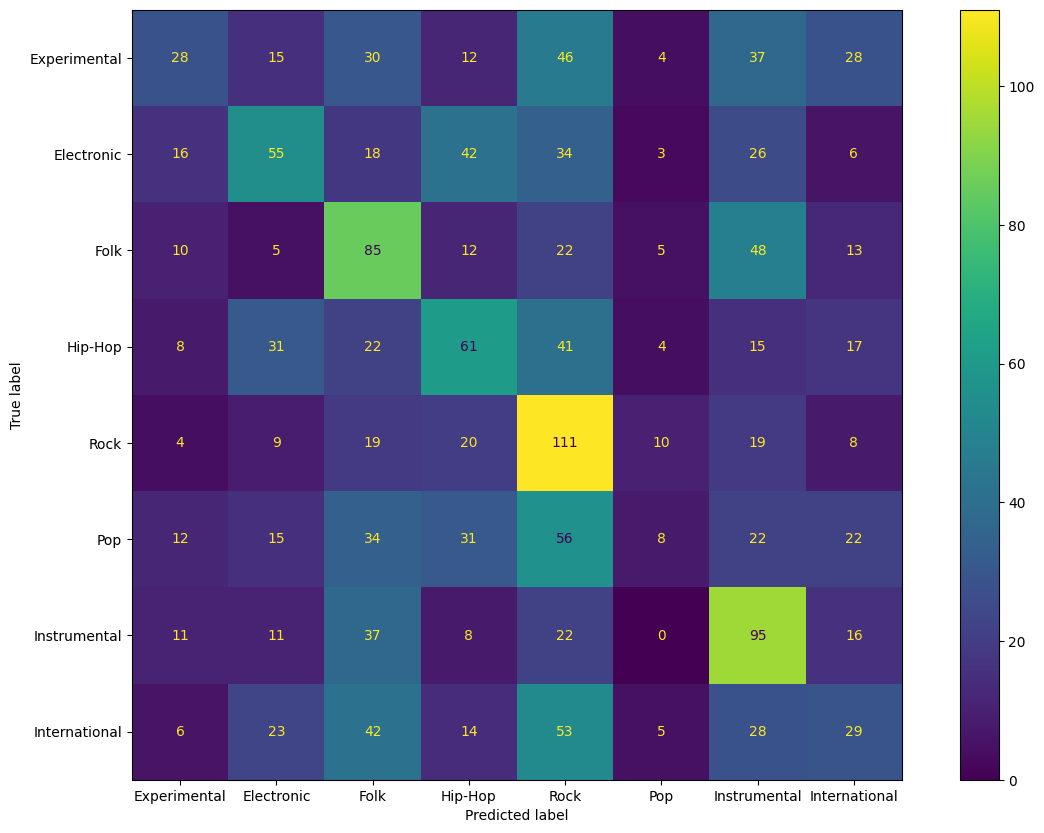

In [ ]:
X_train = np.concatenate((np.stack(train_df['raw'].values), np.stack(val_df['raw'].values)), axis=0)
y_train = np.concatenate((train_df['label'].values, val_df['label'].values))

X_train = X_train[:, np.newaxis, :]

X_test = np.stack(test_df['raw'].values)
X_test = X_test[:, np.newaxis, :]
y_test = test_df['label'].values

model = DetachEnsemble(model_type='pytorch_minirocket', num_models=25, num_kernels=1000)
detach_report['raw'] = fit_and_evaluate(X_train, y_train, X_test, y_test, model)

In [ ]:
# save detach_report
detach_report_df = pd.DataFrame(detach_report)
detach_report_df.to_pickle('detach_report.pkl')

# Comparison Results

In [ ]:
cnn_report_df = pd.read_pickle('cnn_report.pkl')
crnn_report_df = pd.read_pickle('crnn_report.pkl')
time_inception_report_df = pd.read_pickle('time_inception_report.pkl')
detach_report_df = pd.read_pickle('detach_report.pkl')

cnn_report_df = cnn_report_df.add_prefix('CNN_')
crnn_report_df = crnn_report_df.add_prefix('CRNN_')
time_inception_report_df = time_inception_report_df.add_prefix('TIME_INCEPTION_')
detach_report_df = detach_report_df.add_prefix('DETACH_')

results_df = pd.concat([
    cnn_report_df,
    crnn_report_df,
    time_inception_report_df,
    detach_report_df
],  axis=1).transpose()
results_df

Experimental  \
CNN_mfcc                 {'precision': 0.31007751937984496, 'recall': 0...   
CNN_chroma               {'precision': 0.36538461538461536, 'recall': 0...   
CNN_spectral             {'precision': 0.1863799283154122, 'recall': 0....   
CNN_raw                  {'precision': 0.23717948717948717, 'recall': 0...   
CRNN_mfcc                {'precision': 0.3656716417910448, 'recall': 0....   
CRNN_chroma              {'precision': 0.2734375, 'recall': 0.175, 'f1-...   
CRNN_spectral            {'precision': 0.32, 'recall': 0.2, 'f1-score':...   
CRNN_raw                 {'precision': 0.27722772277227725, 'recall': 0...   
TIME_INCEPTION_mfcc      {'precision': 0.4519774011299435, 'recall': 0....   
TIME_INCEPTION_chroma    {'precision': 0.25933609958506226, 'recall': 0...   
TIME_INCEPTION_spectral  {'precision': 0.20607375271149675, 'recall': 0...   
TIME_INCEPTION_raw       {'precision': 0.1724137931034483, 'recall': 0....   
DETACH_mfcc              {'precision': 0.496551724137931, 'recall': 0.3...   
DETACH_chroma            {'precision': 0.4296875, 'recall': 0.275, 'f1-...   
DETACH_spectral          {'precision': 0.3805309734513274, 'recall': 0....   
DETACH_raw               {'precision': 0.29473684210526313, 'recall': 0...   

                                                                Electronic  \
CNN_mfcc                 {'precision': 0.35135135135135137, 'recall': 0...   
CNN_chroma               {'precision': 0.40476190476190477, 'recall': 0...   
CNN_spectral             {'precision': 0.2215568862275449, 'recall': 0....   
CNN_raw                  {'precision': 0.30666666666666664, 'recall': 0...   
CRNN_mfcc                {'precision': 0.41732283464566927, 'recall': 0...   
CRNN_chroma              {'precision': 0.39622641509433965, 'recall': 0...   
CRNN_spectral            {'precision': 0.23423423423423423, 'recall': 0...   
CRNN_raw                 {'precision': 0.2079207920792079, 'recall': 0....   
TIME_INCEPTION_mfcc      {'precision': 0.5387755102040817, 'recall': 0....   
TIME_INCEPTION_chroma    {'precision': 0.7466666666666667, 'recall': 0....   
TIME_INCEPTION_spectral  {'precision': 0.3787878787878788, 'recall': 0....   
TIME_INCEPTION_raw       {'precision': 0.2781065088757396, 'recall': 0....   
DETACH_mfcc              {'precision': 0.5414634146341464, 'recall': 0....   
DETACH_chroma            {'precision': 0.5030674846625767, 'recall': 0....   
DETACH_spectral          {'precision': 0.35833333333333334, 'recall': 0...   
DETACH_raw               {'precision': 0.20863309352517986, 'recall': 0...   

                                                                      Folk  \
CNN_mfcc                 {'precision': 0.2702702702702703, 'recall': 0....   
CNN_chroma               {'precision': 0.2644628099173554, 'recall': 0....   
CNN_spectral             {'precision': 0.15544041450777202, 'recall': 0...   
CNN_raw                  {'precision': 0.24390243902439024, 'recall': 0...   
CRNN_mfcc                {'precision': 0.4305555555555556, 'recall': 0....   
CRNN_chroma              {'precision': 0.2676056338028169, 'recall': 0....   
CRNN_spectral            {'precision': 0.3972602739726027, 'recall': 0....   
CRNN_raw                 {'precision': 0.3125, 'recall': 0.05, 'f1-scor...   
TIME_INCEPTION_mfcc      {'precision': 0.3652694610778443, 'recall': 0....   
TIME_INCEPTION_chroma    {'precision': 0.28289473684210525, 'recall': 0...   
TIME_INCEPTION_spectral  {'precision': 0.4594594594594595, 'recall': 0....   
TIME_INCEPTION_raw       {'precision': 0.2, 'recall': 0.085, 'f1-score'...   
DETACH_mfcc              {'precision': 0.4782608695652174, 'recall': 0....   
DETACH_chroma            {'precision': 0.2692307692307692, 'recall': 0....   
DETACH_spectral          {'precision': 0.2777777777777778, 'recall': 0....   
DETACH_raw               {'precision': 0.20512820512820512, 'recall': 0...   

                                                                   Hip-Hop  \
CNN

In [ ]:
# plot classification macro avg report for each model
plot_df = pd.DataFrame(results_df.loc[:, 'accuracy'])
plot_df['model'] = plot_df.index.str.split('_').str[0]
display(plot_df)
px.bar(plot_df, x=plot_df.index, y='accuracy', color='model', title='Classification Accuracy by Model', labels={'accuracy': 'Accuracy', 'model': 'Model'})

accuracy   model
CNN_mfcc                 0.442151     CNN
CNN_chroma               0.405879     CNN
CNN_spectral              0.24015     CNN
CNN_raw                  0.281426     CNN
CRNN_mfcc                0.497811    CRNN
CRNN_chroma              0.370857    CRNN
CRNN_spectral            0.411507    CRNN
CRNN_raw                 0.268293    CRNN
TIME_INCEPTION_mfcc      0.539712    TIME
TIME_INCEPTION_chroma    0.450907    TIME
TIME_INCEPTION_spectral  0.397749    TIME
TIME_INCEPTION_raw       0.277674    TIME
DETACH_mfcc               0.56035  DETACH
DETACH_chroma            0.457161  DETACH
DETACH_spectral          0.442151  DETACH
DETACH_raw               0.295184  DETACH